In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import pynwb
import graph
import glob
import os
from pathlib import Path 

from sklearn.cluster import KMeans
from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import ttest_rel
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import chi2
from scipy import signal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import matplotlib
from sklearn.metrics import confusion_matrix

# Utility Functions

In [2]:
import collections

def movmean(A, w):
    """
    Calculates the moving mean of a matrix or vector horizontally.

    Args:
        A (np.array): The input matrix or vector. It must be <= 2 dimensions.
        w (int or list or ndarray): The window size for calculating the moving mean.
            If it is an integer, it calculates a centered window of size w around each element.
            If it is a 2-element list or ndarray, it calculates the window w1 elements before and w2 elements after.

    Returns:
        np.array: The moving mean of the input matrix or vector.
    """

    if A.ndim > 2:
        print("Error: input matrix cannot exceed 2 dimensions")
    elif A.ndim <= 1:
        A = A.reshape(1, -1)
    n = A.shape[1]
    if isinstance(w, (collections.abc.Sequence, np.ndarray)):
        params = [w[0], w[1]]
    else:
        params = [w, w]

    weight_matrix = np.tril(np.triu((np.ones([n, n])), -params[1]), params[0])
    return np.dot(A, weight_matrix)/weight_matrix.sum(axis=0)


from matplotlib.colors import LinearSegmentedColormap
def interpolate_colors(color1, color2, num_colors):
    """
    Interpolates a list of colors between two given colors.

    Parameters:
    color1 (str or tuple): The starting color, can be a name or an RGB tuple.
    color2 (str or tuple): The ending color, can be a name or an RGB tuple.
    num_colors (int): The number of colors to generate between color1 and color2.

    Returns:
    list: A list of interpolated colors in RGBA format.
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=num_colors)
    colors = [cmap(i) for i in range(num_colors)]
    return colors


def xy(node, nrows, ncols):
    """
    Transforms the node identity into X, y coordinates
    :param node: (int) node ID
    :param nrows: (int) number of rows
    :param ncols: (int) number of columns
    :return: (X, Y): (tuple) pair of XY coords
    """
    X = int(node % nrows)
    Y = int(np.floor(node / ncols))
    return X, Y

In [3]:
c1 = "#fc0303" # red
c2 = "#d000ff" # purple
c3 = "#0800ff" # blue
c4 = "#03b6fc" # cyan

caxis_1 = interpolate_colors(c1, c2, 4)
caxis_2 = interpolate_colors(c3, c4, 4)
cmap_2d = np.array([interpolate_colors(caxis_1[i], caxis_2[i], 4) for i in range(4)])

In [7]:
def combine_data(DATA_DIR,region,epoch,query,step):
    
    # combine all sessions

    os.chdir(DATA_DIR)
    filenames = glob.glob('*.nwb')
        
    df = pd.DataFrame()
    spikes = [[] for i in range(len(filenames))]
    neuron_df = pd.DataFrame()
    
    for ii, filename in enumerate(filenames):
        
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        temp_spikes, temp_df, _ = get_spike_table(nwbfile, region, epoch, query, window_size=0)

        # look at each step separately
        if step=='first':
            idx = temp_df.step==0
        if step=='middle':
            idx = (temp_df.step<temp_df.nsteps) & (temp_df.step>0)
        if step=='last':
            idx = temp_df.step==temp_df.nsteps
            
        temp_df = temp_df[idx]
        temp_spikes = temp_spikes[idx,:,:]
        
        temp_df['Session'] = ii
        df = pd.concat([df,temp_df])
        spikes[ii] = temp_spikes
    
        n_cell = temp_spikes.shape[2]
        neuron_df_temp = pd.DataFrame({'Session': np.ones(n_cell)*ii, 'ID': np.arange(n_cell)})
        neuron_df = pd.concat([neuron_df,neuron_df_temp])
    
    df['prenode'] = np.insert(df.node.values[:-1], 0, -1)
    df['postnode'] = np.insert(df.node.values[1:], -1, -1)
    # df.loc[df.step==0,'prenode'] = -1
    # df.loc[df.step==df.nsteps,'postnode'] = -1

    return df, spikes, neuron_df

In [9]:
DATA_DIR = Path('/Volumes/Extreme SSD')
choice_df_all, choice_spikes_all, neuron_df = combine_data(DATA_DIR,"HPC","action_on","trialerror == 0",'first')

NameError: name 'get_spike_table' is not defined

In [87]:
def plot_psth2(ax,var,df,spikes): 

    for node in np.arange(0, 16):
        
        idx = df[var].values == node
        x, y = xy(node, 4, 4)
        trace = movmean(np.mean(spikes[idx,:,int(nid)],axis=0)*1000, w=75).flatten()
        t = np.arange(-500, 500)
        ax.plot(t,trace,c= cmap_2d[x, y])
        ax.axvline(0,color='k',linestyle='--',lw=0.8)
        ax.set_title(var)

In [19]:
sz1 = 12
sz2 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

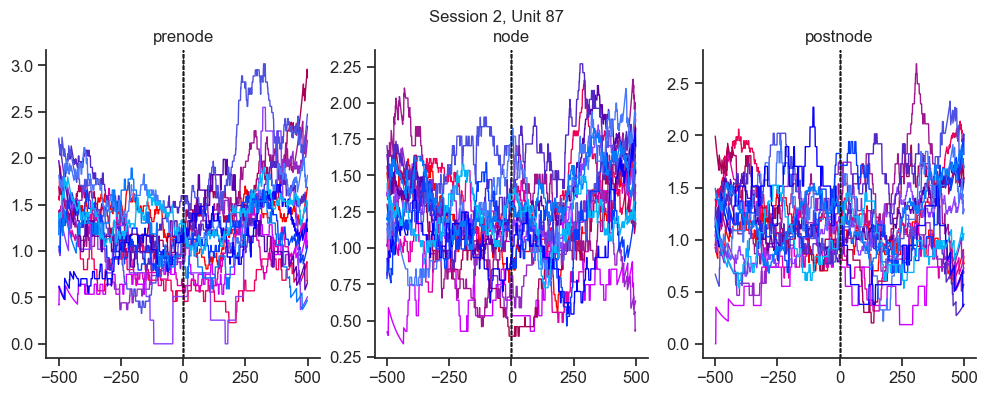

In [93]:
vars = ['prenode','node','postnode']

for cell in range(len(neuron_df)):
    
    ses, nid = neuron_df.iloc[cell].values
    df = choice_df.query("Session==@ses")
    spikes = choice_spikes[int(ses)]
    
    plt.close('all')
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    
    for ii in range(3): 
        
        plot_psth2(ax[ii],vars[ii],df,spikes)
        
    plt.suptitle('Session %i, Unit %i'%(ses, nid))
    plt.savefig('Session %i, Unit %i, pre, curr, post'%(ses, nid))

# NWB Tutorial
the NWBfile is an object that orgnaizes data for 'easy' analysis. There are several important datastructures in an NWBfile:

In [4]:
filename = "D:/Teleworld/bart_I/processed/Bart_TeleWorld_v13_032823.nwb"  # Replace with your NWB file path
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

unitNames = nwbfile.units.to_dataframe()
# get good units
unit_idx = np.where((unitNames.region == "HPC") & (unitNames.group == "good") & (unitNames.drift <= 2) & (unitNames.fr >= 1))[0]


In [17]:
nwbfile.intervals.keys()

dict_keys(['action_on', 'fixations', 'fixations_blocked', 'node_on', 'reward_on', 'ripple', 'trials'])

### Acquisition (Array-like): These contain the important timeseries data: spikes, LFP, eventcodes, and eyetracking.

In [13]:
# example: Getting spiking data
nwbfile.acquisition["neural"]

Data type,uint8
Shape,"(5348899, 191)"
Array size,974.31 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0


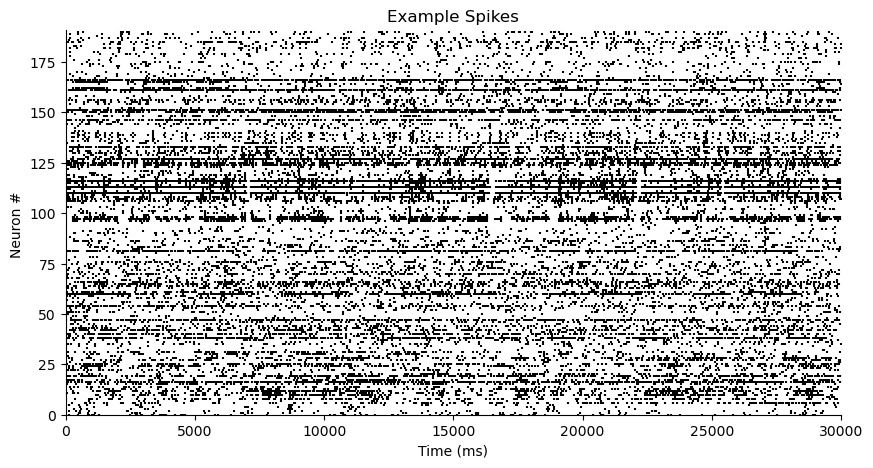

In [15]:
# Example spike raster
fig, ax = plt.subplots(1, figsize=(10, 5))

# Example start and stop times for the spike raster
example_start_time = 30000
example_stop_time = 60000

# Extracting spikes from the neural data
spikes = nwbfile.acquisition["neural"].data[example_start_time:example_stop_time, :]

# Plotting the spike raster
X, Y = np.where(spikes)
ax.scatter(X, Y, marker = "|", c="k", s=1)
ax.set_xlim([0, spikes.shape[0]])
ax.set_ylim([0, spikes.shape[1]])

ax.set_ylabel("Neuron # ")
ax.set_xlabel("Time (ms)")
ax.set_title("Example Spikes")

sns.despine()

### Intervals (table-like): these contain important meta-data about the session, such as trial information, or information about each choice

In [389]:
# Data for all isolated neurons
unitNames = nwbfile.units.to_dataframe()
unitNames.head()

,unitNumber,unitNames,channelNumbers,unitOnChannel,probe,firingRate,date,region,ap,ml,...,start_channel,end_channel,cell_community,potential_duplicate,keep_cell,subfield,drift,group,fr,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
1,1,S01_SPK001_001,1,1,1,14.159935,31723,OFC,35.5,7.8,...,1,32,165.0,1.0,1.0,OFC,0.0,good,14.159935,"[-0.0004036059758216426, -0.000484967136023632..."
2,2,S01_SPK002_001,2,1,1,0.425577,31723,OFC,35.5,7.8,...,1,32,164.0,1.0,1.0,OFC,0.0,good,0.425577,"[0.000370086350203209, 0.00038839570697001886,..."
3,3,S01_SPK002_002,2,2,1,11.661634,31723,OFC,35.5,7.8,...,1,32,163.0,1.0,1.0,OFC,0.0,good,11.661634,"[0.0003140746071562055, 0.0003614533787823697,..."
4,4,S01_SPK003_001,3,1,1,3.368522,31723,OFC,35.5,7.8,...,1,32,162.0,1.0,1.0,OFC,0.0,good,3.368522,"[-0.0012488040760779164, -0.001338943720262359..."
5,5,S01_SPK003_002,3,2,1,2.921286,31723,OFC,35.5,7.8,...,1,32,161.0,1.0,1.0,OFC,0.0,good,2.921286,"[0.002873275324049746, 0.00289063769809451, 0...."


In [5]:
# data for each trial
trial_df = nwbfile.trials.to_dataframe()
trial_df.head()

,start_time,stop_time,trial,trialerror,nsteps,start,target,block,blocktrialnumber,nodes,timeseries
id,,,,,,,,,,,
0,10966.0,13149.0,0,1.0,0.0,1.0,1.0,1.0,1.0,1,"[(10966, 2183, neural pynwb.base.TimeSeries at..."
1,14602.0,16778.0,1,1.0,0.0,1.0,1.0,1.0,2.0,1,"[(14602, 2176, neural pynwb.base.TimeSeries at..."
2,18231.0,24176.0,2,0.0,4.0,14.0,1.0,1.0,3.0,"14,10,6,2,1","[(18231, 5945, neural pynwb.base.TimeSeries at..."
3,25629.0,29656.0,3,0.0,2.0,15.0,1.0,1.0,4.0,"15,0,1","[(25629, 4027, neural pynwb.base.TimeSeries at..."
4,31111.0,34942.0,4,0.0,2.0,15.0,1.0,1.0,5.0,"15,0,1","[(31111, 3831, neural pynwb.base.TimeSeries at..."


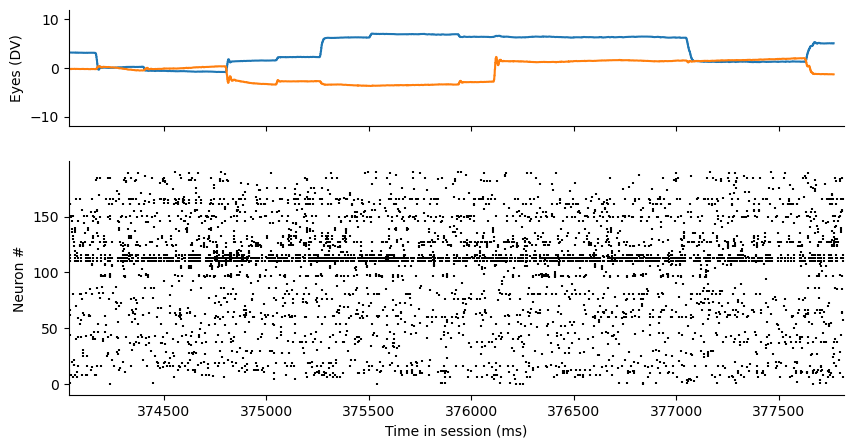

In [24]:
# get neural data associated with a trial:
# timeseries in the 'timeseries' column must be indexed with integers
neural_idx = 0
eye_idx = 2

# pull trial for a single trial
trial = 60
spikes = trial_df.iloc[trial, :].timeseries[neural_idx]
eyes = trial_df.iloc[trial, :].timeseries[eye_idx]

fig, ax = plt.subplots(2, 1, figsize=(10, 5), height_ratios=[1, 2], sharex=True)
# plot eyetracking data
ax[0].plot(eyes.timestamps, eyes.data)
ax[0].set_ylabel("Eyes (DV)")
ax[0].set_ylim([-12, 12])

# plot spike raster
X, Y = np.where(spikes.data)
X = (X + spikes.timestamps[0])
ax[1].scatter(X, Y, marker = "|", c="k", s=1)
ax[1].set_xlim(spikes.timestamps[0], spikes.timestamps[-1])
ax[1].set_ylabel("Neuron #")
ax[1].set_xlabel("Time in session (ms)")
sns.despine()

In [431]:
# data for each choice
choice_df = nwbfile.intervals["action_on"].to_dataframe()
choice_df.head()

,start_time,stop_time,trial,step,trialerror,nsteps,start,target,block,blocktrialnumber,node,t_on,graph_distance,spatial_distance,window_size,nodes,timeseries
id,,,,,,,,,,,,,,,,,
0,11327.0,12327.0,0,0,1.0,0.0,1.0,1.0,1.0,1.0,1,11827.0,0,0,500,1,"[(11327, 1000, neural pynwb.base.TimeSeries at..."
1,14960.0,15960.0,1,0,1.0,0.0,1.0,1.0,1.0,2.0,1,15460.0,0,0,500,1,"[(14960, 1000, neural pynwb.base.TimeSeries at..."
2,18610.0,19610.0,2,0,0.0,4.0,14.0,1.0,1.0,3.0,14,19110.0,3,4,500,"14,10,6,2,1","[(18610, 1000, neural pynwb.base.TimeSeries at..."
3,19141.0,20141.0,2,1,0.0,4.0,14.0,1.0,1.0,3.0,10,19641.0,3,3,500,"14,10,6,2,1","[(19141, 1000, neural pynwb.base.TimeSeries at..."
4,20052.0,21052.0,2,2,0.0,4.0,14.0,1.0,1.0,3.0,6,20552.0,2,2,500,"14,10,6,2,1","[(20052, 1000, neural pynwb.base.TimeSeries at..."


In [11]:
def get_spike_table(nwbfile, region, epoch, query="", window_size=0, unit_params = {"drift": 2, "min_fr": 1}):
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"
    
    unitNames = nwbfile.units.to_dataframe()
    # get good units
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)
    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
    
    epoch_win_size = df["window_size"].values[0]
    sample_index = df.index
    spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
    print("Building Spike Table")
    if window_size != 0:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            sample_data = movmean(sample_data.T, window_size).T
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    else:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
            
    df = graph.append_use_tele(df)
    return spikes, df, unitNames

In [33]:
filename = "Bart_TeleWorld_v13_032823.nwb"
nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
choice_df = nwbfile.intervals["action_on"].to_dataframe()
choice_spikes, choice_df, _ = get_spike_table(nwbfile, "HPC", "action_on", query="trialerror == 0", window_size=0)

Building Spike Table


1860it [00:01, 1283.48it/s]


In [61]:
ii

2

In [59]:
np.divmod(ii,4)

(0, 2)

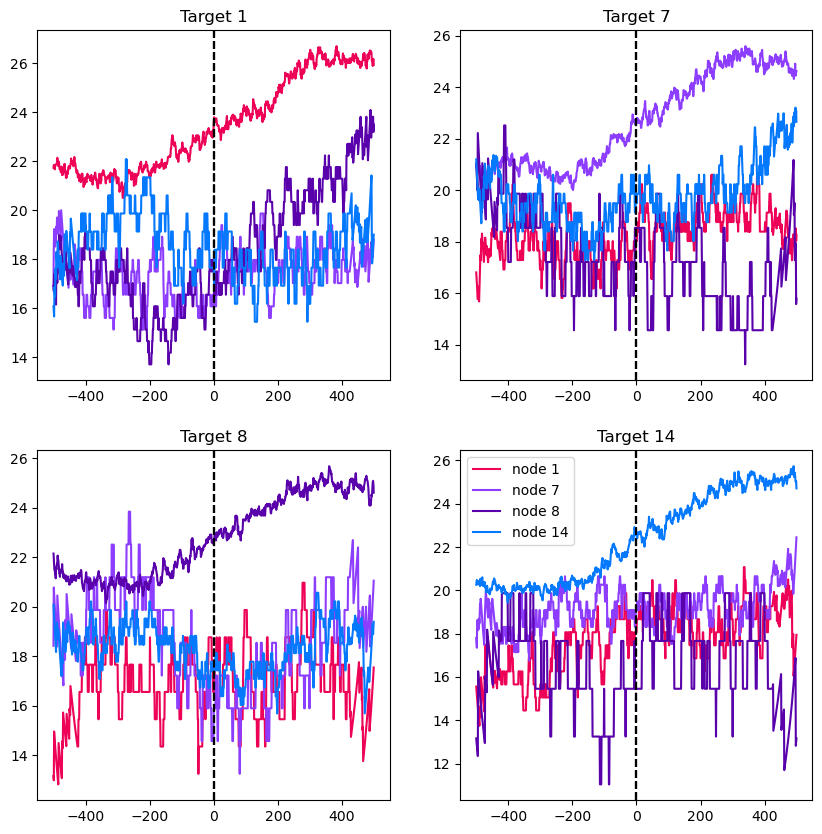

In [67]:
cell=83


fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for ii, target in enumerate([1,7,8,14]):

    r,c = np.divmod(ii,2)

    for node in [1,7,8,14]:
    
        x, y = xy(node, 4, 4)            

        t = np.arange(-500, 500)
        
        idx = (choice_df.node.values==node) & (choice_df.target.values==target)
        spikes_choices = choice_spikes[idx, :, cell]
        trace = movmean(np.nanmean(spikes_choices,axis=0)*1000, w=75).flatten()
        
        ax[r,c].plot(t, trace, c= cmap_2d[x, y], label='node %i' % node)
        ax[r,c].axvline(0, color='k', linestyle='--')
        ax[r,c].set_title('Target %i' % target)

        if ii==3:
            ax[r,c].legend()

In [459]:
    choice_df['prenode'] = np.insert(choice_df.node.values[:-1], 0, -1)
    choice_df['postnode'] = np.insert(choice_df.node.values[1:], -1, -1)
    choice_df.loc[choice_df.step==0,'prenode'] = -1
    choice_df.loc[choice_df.step==choice_df.nsteps,'postnode'] = -1

In [473]:
def information_score(spikes,cell,labels,timestamps,w=100):

    """
    timestamps: center of the window
    w: 1/2 width of the window
    Pi = probability of occupying a given node
    lambda_i = mean FR for a given node
    lambda = mean FR across all nodes
    """

    uni_label = np.unique(labels)
    Pi = np.array([np.mean(labels==g) for g in uni_label])
    IC = np.zeros(len(timestamps))
    lambda_all = np.zeros(len(timestamps))
    lambda_i = np.zeros((len(timestamps),len(uni_label)))

    for ii, ts in enumerate(timestamps):
        
        lambda_all[ii] = spikes[:, ts-w:ts+w, cell].mean(axis=(0, 1))*1000

        if lambda_all[ii]>0: 
            
            lambda_i[ii,:] = np.array([spikes[labels == g, ts-w:ts+w, cell].mean() 
                      for g in uni_label])*1000
            x = lambda_i[ii, :] / lambda_all[ii]
            valid = x > 0  # Only consider positive values
            IC[ii] = np.sum(Pi[valid] * x[valid] * np.log2(x[valid]))
            
        else:
            IC[ii] = 0

    
    return IC, lambda_all, lambda_i

In [475]:
# previous node + current node

window = 100
N_shuffle = 1000

timestamps = np.arange(window,1001-window,50)
N_ts = len(timestamps)
N_cell = choice_spikes.shape[2] # number of cells

idx = choice_df['prenode'].values>-1
prenodes = choice_df['prenode'].values[idx]
nodes = choice_df['node'].values[idx]
data_labels = np.array([int(str(a) + str(b)) for a, b in zip(prenodes, nodes)])
spikes = choice_spikes[idx,:,:]

score = np.zeros((N_cell,N_ts))
Lambda_all = np.zeros((N_cell,N_ts))
Lambda_i = np.zeros((N_cell,N_ts,len(np.unique(data_labels))))
null = np.zeros((N_cell,N_shuffle,N_ts))
sig = np.zeros((N_cell,N_ts))

for cell in tqdm(range(N_cell)):
    
    score[cell,:], Lambda_all[cell,:], Lambda_i[cell,:,:] = information_score(spikes,cell,data_labels,timestamps)



100%|███████████████████████████████████████████| 88/88 [00:06<00:00, 14.06it/s]


In [479]:
np.argsort(score[:,8])

array([14, 25, 17,  1, 63, 26, 10, 32,  0, 15,  2, 38, 28, 13, 11, 48, 16,
       12, 24, 29, 58,  9, 53, 59, 62, 37, 46,  7, 73, 27, 51, 64, 44,  6,
       20, 75, 82, 34, 31, 85, 76, 56, 65, 39, 22, 67, 79,  3, 19, 21, 49,
       74, 71, 36, 72, 43, 30,  4, 54, 81, 18, 33, 80, 69,  5, 40, 68, 23,
       83, 41, 52, 55, 47, 57, 77, 86, 60, 70, 66, 78,  8, 50, 87, 61, 35,
       42, 45, 84])

Text(0.5, 1.0, 'Unit 66 choice')

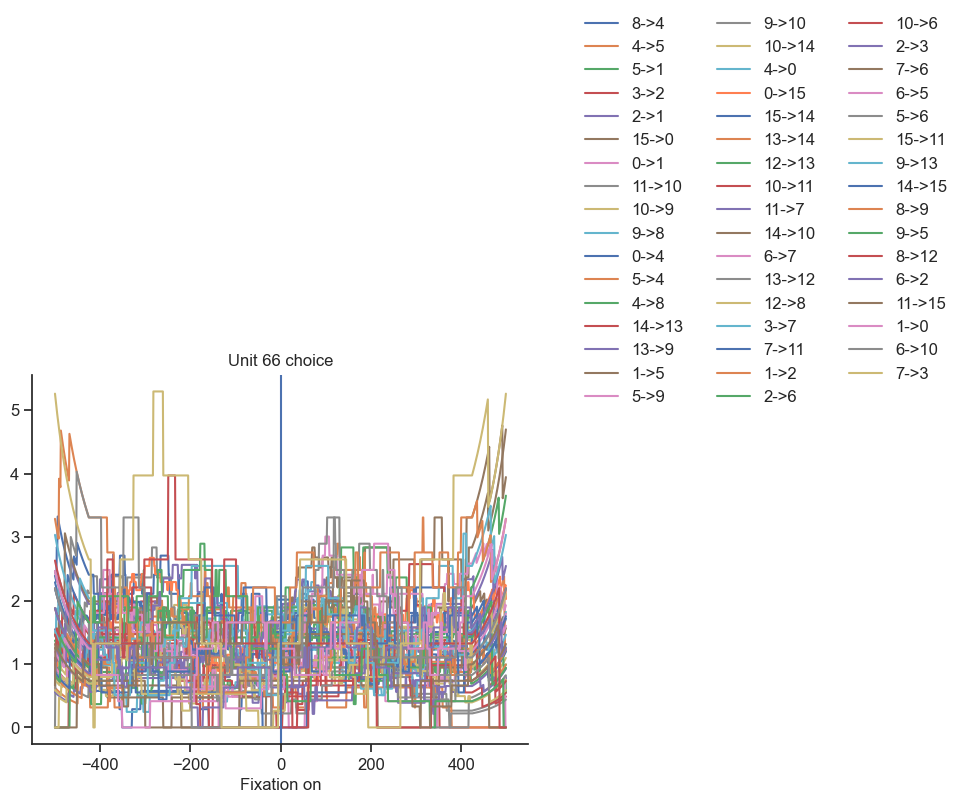

In [497]:
plt.close('all')
t = np.arange(-500,500)
cell=66

idx = choice_df.prenode>-1
df = choice_df.query("prenode>-1")
spikes = choice_spikes[idx,:,:]

for val1, val2 in df[['node', 'prenode']].drop_duplicates().values:
    
    fix_idx = (df.node==val1) & (df.prenode==val2)
    trace = movmean(np.mean(spikes[fix_idx,:,cell],axis=0)*1000, w=75).flatten()
    if (val1==15) & (val2==0):
        plt.plot(t,trace,label=str(val2)+'->'+str(val1),color='coral')
    else:
        plt.plot(t,trace,label=str(val2)+'->'+str(val1))

# fix_idx = (fix_df.fix_node==0) & (fix_df.choice)
# trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
# plt.plot(trace,color='k')
plt.legend(frameon=False,ncols=3,loc=(1.1,0.9))
plt.xlabel('Fixation on')
plt.axvline()
# plt.ylim(5,50)
plt.title('Unit %i choice'%cell)

In [433]:
choice_spikes, choice_df, unitNames = get_spike_table(nwbfile, "HPC", "action_on", query="trialerror == 0", window_size=0)

choice_df['prenode'] = np.insert(choice_df.node.values[:-1], 0, -1)
choice_df['postnode'] = np.insert(choice_df.node.values[1:], -1, -1)

choice_df.loc[choice_df.step==0,'prenode'] = -1
choice_df.loc[choice_df.step==choice_df.nsteps,'postnode'] = -1

Building Spike Table


1860it [00:01, 1699.70it/s]


In [405]:
region="HPC"
unit_params = {"drift": 2, "min_fr": 1}
neural_timeseries_index = 0

epoch_win_size = choice_df["window_size"].values[0]
unitNames = nwbfile.units.to_dataframe()
# get good units
unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]


In [407]:
# need to incorporate this into get_spike_table_fix

trial_df = nwbfile.trials.to_dataframe().query("trialerror == 0")
fix_df = nwbfile.intervals["fixations"].to_dataframe().query("(trialerror == 0) & (duration >= 50)")

spikes = np.zeros((len(fix_df), epoch_win_size*2, len(unit_idx)), dtype=np.float32)

trial_index = trial_df.index
fix_idx = 0

for ii, trial in tqdm(enumerate(trial_index)):
    
    trial_spikes = trial_df.iloc[ii].timeseries[neural_timeseries_index]
    trial_start = trial_df.iloc[ii].start_time

    fixations_during_trial = fix_df.query("trial == @ trial")


    for _, fix in fixations_during_trial.iterrows():

        sample_data = np.zeros((epoch_win_size*2, len(unit_idx)), dtype=np.float32)*np.nan

        in_trial = np.isin(np.arange(fix.start_time - epoch_win_size,fix.start_time + epoch_win_size),trial_spikes.timestamps)

        time_idx = (trial_spikes.timestamps >= fix.start_time - epoch_win_size) & (trial_spikes.timestamps < fix.start_time + epoch_win_size)
        
        sample_data[in_trial] = trial_spikes.data[time_idx, :][:, unit_idx]
        spikes[fix_idx, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
        fix_idx = fix_idx + 1

fix_spikes = spikes.copy()
fix_df['planning'] = (fix_df.duration<300) & (fix.active_prob<0.2)
fix_df['choice'] = (fix_df.duration>300) & (fix_df.active_prob>0.2)

492it [00:05, 95.17it/s] 


In [2267]:
choice_spikes = np.concatenate((choice_spikes,np.reshape((choice_spikes[:, :, 31] + choice_spikes[:, :, 34])>0,(-1,1000,1))),axis=2)
fix_spikes = np.concatenate((fix_spikes,np.reshape((fix_spikes[:, :, 31] + fix_spikes[:, :, 34])>0,(-1,1000,1))),axis=2)

In [1385]:
def get_spike_table_fix(nwbfile, region, epoch="fixations", query="", window_size=0, unit_params = {"drift": 2, "min_fr": 1}):
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"
    
    unitNames = nwbfile.units.to_dataframe()
    # get good units
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)
    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
    
    epoch_win_size = df["window_size"].values[0]
    sample_index = df.index
    spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
    print("Building Spike Table")
    if window_size != 0:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            sample_data = movmean(sample_data.T, window_size).T
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    else:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
            
    df = graph.append_use_tele(df)
    return spikes, df, unitNames

# choice_spikes, choice_df, unitNames = get_spike_table(nwbfile, "HPC", "action_on", query="trialerror == 0", window_size=0)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_36407/3454633514.py:21: RuntimeWarning: Mean of empty slice
  trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_36407/3454633514.py:21: RuntimeWarning: Mean of empty slice
  trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_36407/3454633514.py:21: RuntimeWarning: Mean of empty slice
  trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_36407/3454633514.py:21: RuntimeWarning: Mean of empty slice
  trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_36407/3454633514.py:21: RuntimeWarning: Mean of empty slice
  trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
/var/folders/vp/0ygv

KeyboardInterrupt: 

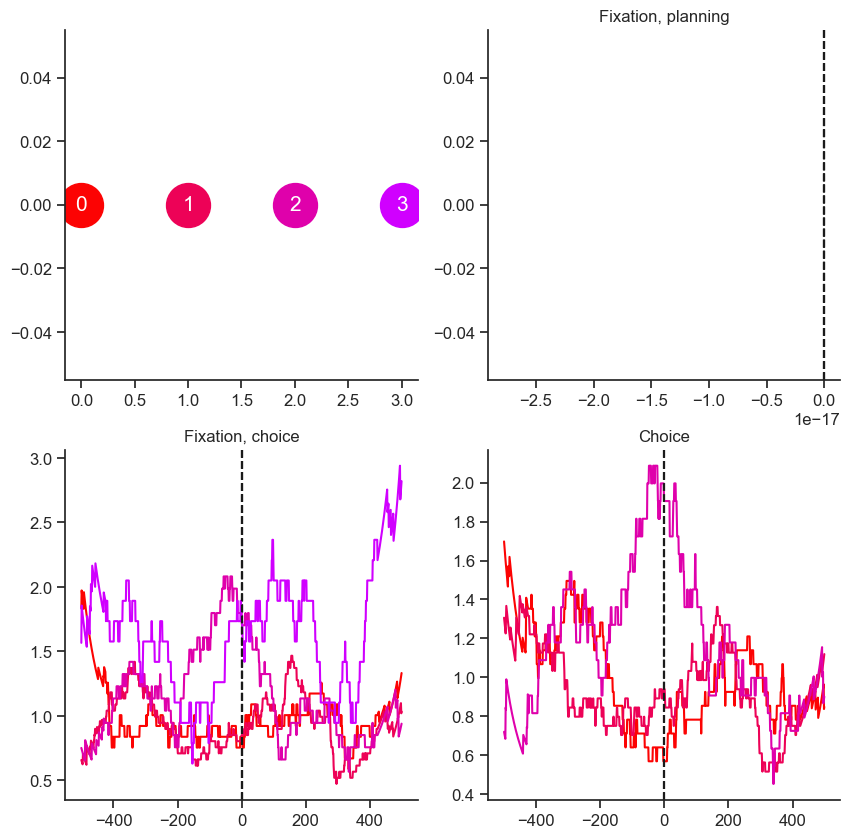

In [409]:
for cell in range(fix_spikes.shape[2]):
    plt.close('all')
    plot_psth_fix(cell)
    plt.savefig('Session 2, HPC Unit '+str(cell)+' planning vs choice.jpg')

In [1]:
fixations_during_trial

NameError: name 'fixations_during_trial' is not defined

0 15
1 4
2 0


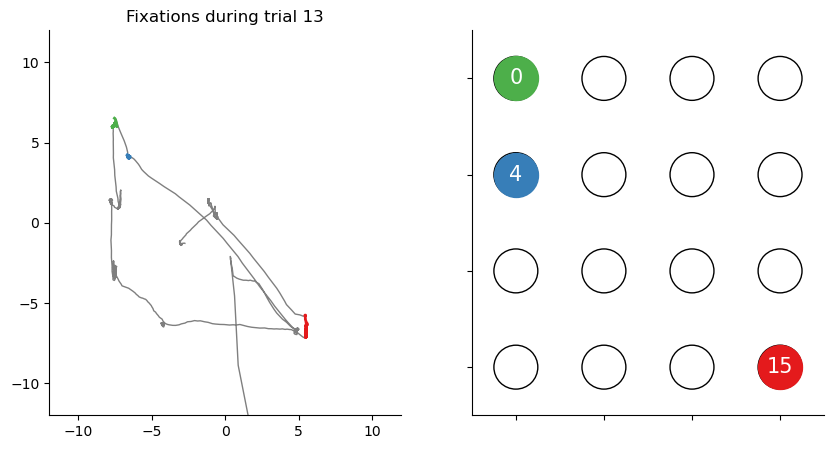

In [2109]:
trial = 13

fixations_during_trial = nwbfile.intervals["fixations"].to_dataframe().query("(trial == @ trial) & (duration >= 50)")

eye_idx = 2

# pull trial for a single trial
eyes = trial_df[trial_df.trial==trial].timeseries.iloc[0][eye_idx]

color_seq = sns.color_palette('Set1',len(fixations_during_trial))
ii=0

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)

for node in np.arange(0, 16):
    x, y = xy(node, 4, 4)
    ax[1].scatter(x, y, s=1000, color = 'k',marker='o',facecolors='none')
    ax[1].text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')


# for k in range(2):
for _, fix in fixations_during_trial.iterrows():

    if ii<3:
    
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        
        ax[0].plot(fixation_trace[:, 0], fixation_trace[:, 1], c=color_seq[ii], lw=2)
            
        node = fix.fix_node
        print(ii,node)
        x, y = xy(node, 4, 4)
        ax[1].scatter(x, y, s=1000, color = color_seq[ii])

    ii=ii+1


ax[0].set_ylim([-12, 12])
ax[0].set_xlim([-12, 12])
ax[0].set_title("Fixations during trial %i" % trial)

ax[1].set_xlim([-0.5, 3.5])
ax[1].set_ylim([-0.5, 3.5])
ax[1].set_xticks([0, 1, 2, 3], labels = ["", "", "", ""])
ax[1].set_yticks([0, 1, 2, 3], labels = ["", "", "", ""])
ax[1].invert_yaxis()  # Invert the y-axis

sns.despine(bottom=False,left=False)


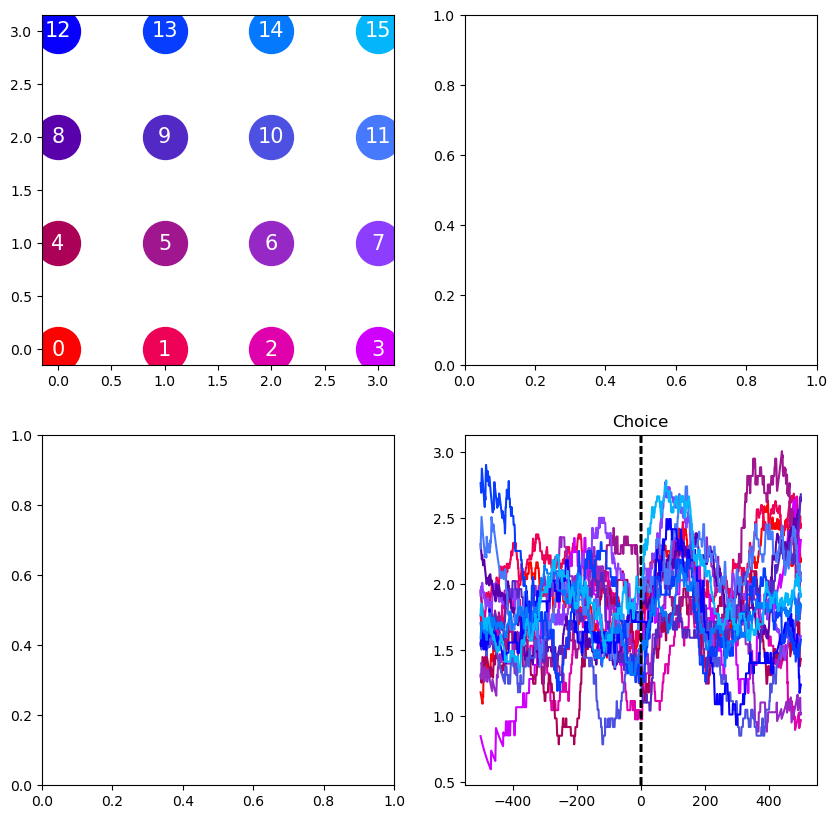

In [23]:
spikes_choices = choice_spikes[:, :, cell]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
   
for node in np.arange(0, 16):

    x, y = xy(node, 4, 4)            
    ax[0,0].scatter(x, y, s=1000, color = cmap_2d[x, y])
    ax[0,0].text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')

    t = np.arange(-500, 500)
    
    
    idx = choice_df.node.values==node
    trace = movmean(np.nanmean(spikes_choices[idx,:],axis=0)*1000, w=75).flatten()
    r=1
    c=1
    ax[r,c].plot(t, trace, c= cmap_2d[x, y])
    ax[r,c].axvline(0, color='k', linestyle='--')
    ax[r,c].set_title('Choice')

In [19]:
# for cell in range(spikes.shape[2]):
cell=83
plt.close('all')
plot_psth_fix(choice_spikes, choice_df, cell)
fig.suptitle("HPC Unit %i, Aligned to all fixations" % cell)
# plt.savefig('HPC Unit '+str(cell)+' fixations.jpg')

NameError: name 'plot_psth_fix' is not defined

In [ ]:
### RSA for planning v.s. choice

## null distribution, half-split planning / choice

In [ ]:
## population decoding

In [21]:
def plot_psth_fix(cell):

    if np.isscalar(cell):
        spikes_fix = fix_spikes[:, :, cell]
        spikes_choices = choice_spikes[:, :, cell]
    else:
        spikes_fix = (fix_spikes[:, :, cell[0]] + fix_spikes[:, :, cell[1]])>0
        spikes_choices = (choice_spikes[:, :, cell[0]] + choice_spikes[:, :, cell[1]])>0        
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
       
    for node in np.arange(0, 16):

        x, y = xy(node, 4, 4)            
        ax[0,0].scatter(x, y, s=1000, color = cmap_2d[x, y])
        ax[0,0].text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')

        t = np.arange(-500, 500)
        
        idx = (fix_df.planning.values) & (fix_df.fix_node.values==node)
        trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
        r=0
        c=1
        ax[r,c].plot(t, trace, c= cmap_2d[x, y])
        ax[r,c].axvline(0, color='k', linestyle='--')
        ax[r,c].set_title('Fixation, planning')
        
        idx = (fix_df.choice.values) & (fix_df.fix_node.values==node)
        trace = movmean(np.nanmean(spikes_fix[idx,:],axis=0)*1000, w=75).flatten()
        r=1
        c=0
        ax[r,c].plot(t, trace, c= cmap_2d[x, y])
        ax[r,c].axvline(0, color='k', linestyle='--')
        ax[r,c].set_title('Fixation, choice')
        
        idx = choice_df.node.values==node
        trace = movmean(np.nanmean(spikes_choices[idx,:],axis=0)*1000, w=75).flatten()
        r=1
        c=1
        ax[r,c].plot(t, trace, c= cmap_2d[x, y])
        ax[r,c].axvline(0, color='k', linestyle='--')
        ax[r,c].set_title('Choice')
        
    ax[0,0].set_xlim([-0.5, 3.5])
    ax[0,0].set_ylim([-0.5, 3.5])
    ax[0,0].set_xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    ax[0,0].set_yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    ax[0,0].invert_yaxis()  # Invert the y-axis

    sns.despine()

    plt.suptitle('Session 2 HPC Unit #'+str(cell))
    
    return fig, ax 

In [3025]:
colors[0] ='r'
colors[15] = 'b'
colors[1] = 'g'

In [2999]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [65]:
labels = choice_df.node.values

lambda_i = np.array([choice_spikes[labels == g, 500:800, 60].mean() 
          for g in np.arange(16)])*1000


In [ ]:
filename = "D:/Teleworld/bart_I/processed/Bart_TeleWorld_v13_033123.nwb"  # Replace with your NWB file path
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

unitNames = nwbfile.units.to_dataframe()
# get good units
unit_idx = np.where((unitNames.region == "HPC") & (unitNames.group == "good") & (unitNames.drift <= 2) & (unitNames.fr >= 1))[0]


trial_df = nwbfile.intervals['trials'].to_dataframe()

choice_df = nwbfile.intervals['action_on'].to_dataframe()
choice_df = graph.append_use_tele(choice_df)

fix_df = nwbfile.intervals['fixations_blocked'].to_dataframe()
fix_df = graph.append_use_tele(fix_df)

neural_timeseries_index=0

# beh['nextnode'] = (
#     beh
#     .groupby('trial')['node']
#     .shift(-1)
# )
choice_df['prenode'] = (
    choice_df
    .groupby('trial')['node']
    .shift(1)
)
fix_df['prenode'] = (
    fix_df
    .groupby('trial')['fix_node']
    .shift(1)
)
# beh['step_save']=beh['spatial_distance']-beh['graph_distance']

# get data aligned to node 0 and then node 15 in a trial, choice fixations

colors = sns.color_palette('Set1',16)

nodes = [0,15]

tele_trials = choice_df.query("(use_tele) & (target==14)").copy()
trial_idx = tele_trials.trial.unique()
ts = np.arange(-500,1500)
sample_data = np.zeros((2,len(trial_idx),2000))*np.nan
start_times_all = np.zeros((2,len(trial_idx)))

for ii, tt in enumerate(trial_idx):
    
    trial_timeseries = trial_df.query("trial==@tt").iloc[0].timeseries[neural_timeseries_index]
    trial_ts = trial_timeseries.timestamps
    trial_spikes = trial_timeseries.data[:,unit_idx]
    cell_trial_spikes = (trial_spikes[:,31]+trial_spikes[:,34])>0
    
    choices_per_trial = choice_df.query("trial==@tt")
    choice_idx = np.where((choices_per_trial.node==nodes[1])&(choices_per_trial.prenode==nodes[0]))[0][0]
    choices_per_trial = choices_per_trial.iloc[choice_idx-1:choice_idx+1,:]
    start_times = choices_per_trial.t_on.values
    start_times_all[:,ii] = start_times
    
    for jj in range(2):
        
        time_idx = (trial_ts >= start_times[jj] - 500) & (trial_ts < start_times[jj] + 1500)
        sample_data[jj,ii,:] = cell_trial_spikes[time_idx]


# sort spikes by node, choice fixations

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(8,5),facecolor=(1, 1, 1))

for jj in range(2):
    # plot spike raster
    X, Y = np.where(sample_data[jj])
    axs[jj].scatter(Y-500, X+45, marker = "|", c="k", s=20)
    axs[jj].plot(np.arange(-500,1500),movmean(sample_data[jj].mean(axis=0)*1000, w=75).flatten(),'k-')
    sns.despine()
    
    
    for ii, tt in enumerate(trial_idx):
    
        fix_idx = ((fix_df.start_time >= start_times_all[jj,ii] - 500) & (fix_df.start_time < start_times_all[jj,ii] + 1500)) | \
                    ((fix_df.stop_time >= start_times_all[jj,ii] - 500) & (fix_df.stop_time < start_times_all[jj,ii] + 1500)) 
        fixations_per_choice = fix_df[fix_idx]
    
        fixation_starts = fixations_per_choice.start_time.values - start_times_all[jj,ii] 
        fixation_stops = fixations_per_choice.stop_time.values - start_times_all[jj,ii] 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for ff in range(len(fixations_per_choice)):
            axs[jj].fill_betweenx([ii+45-0.5, ii+45+0.5],fixation_starts[ff],fixation_stops[ff],color = colors[fixation_nodes[ff]],alpha=0.01)
    
    axs[jj].set_xlim(-500,1500)
    axs[jj].set_xlabel('Action on, Node '+str(nodes[jj]))
    
    if jj==1:
        axs[jj].set_yticks([])
        axs[jj].spines[['left','right', 'top']].set_visible(False)
    else:
        axs[jj].set_ylabel('Trial number')

    axs[jj].plot([0,0],[0,90],'k--')
    axs[jj].set_ylim(5,90)
    

for cc in [0,14,15]:
    axs[jj].fill_betweenx([0, 0],0,0,color = colors[cc],alpha=0.1,label='Node '+str(cc))
    
plt.legend(loc=(0.45,0.25),frameon=False)
plt.suptitle('Teleport: 0 -> 15')
plt.savefig('HPC Unit 88 teleport 0 to 15.jpg')

In [3209]:
nodes = [15,0]

tele_trials_idx = (fix_df.fix_node==nodes[0]) & (fix_df.postnode==nodes[1]) & (fix_df.planning)
tele_trials = fix_df[tele_trials_idx]
trial_idx = tele_trials.trial.values

ts = np.arange(-500,1500)
sample_data = np.zeros((2,len(trial_idx),2000))*np.nan
start_times_all = np.zeros((2,len(trial_idx)))

for ii, tt in enumerate(trial_idx):

    trial_timeseries = trial_df.query("trial==@tt").iloc[0].timeseries[neural_timeseries_index]
    trial_ts = trial_timeseries.timestamps
    trial_spikes = trial_timeseries.data[:,unit_idx]
    cell_trial_spikes = (trial_spikes[:,31]+trial_spikes[:,34])>0

    fix_idx = np.where(tele_trials_idx)[0][ii]
    fixations_per_trial = fix_df.iloc[fix_idx:fix_idx+2,:]
    start_times = fixations_per_trial.start_time.values
    start_times_all[:,ii] = start_times

    for jj in range(2):
    
        time_idx = (trial_ts >= start_times[jj] - 500) & (trial_ts < start_times[jj] + 1500)
        sample_data[jj,ii,:] = cell_trial_spikes[time_idx]
    

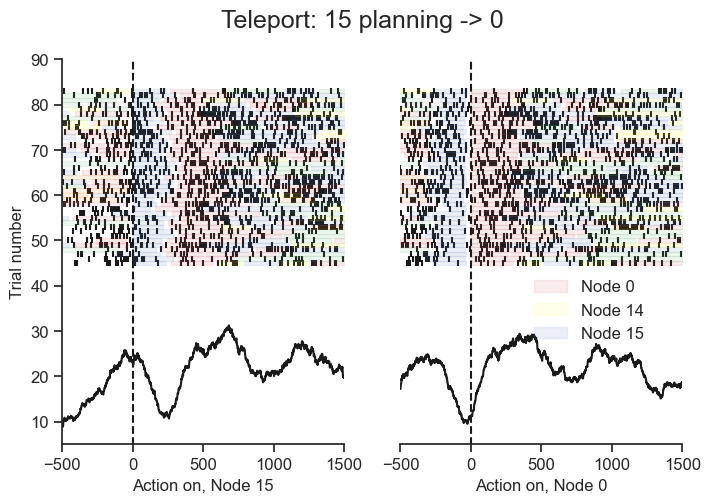

In [3211]:
# sort spikes by node, choice fixations

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(8,5),facecolor=(1, 1, 1))

for jj in range(2):
    # plot spike raster
    X, Y = np.where(sample_data[jj])
    axs[jj].scatter(Y-500, X+45, marker = "|", c="k", s=20)
    axs[jj].plot(np.arange(-500,1500),movmean(sample_data[jj].mean(axis=0)*1000, w=75).flatten(),'k-')
    sns.despine()
    
    for ii, tt in enumerate(trial_idx):
    
        fix_idx = ((fix_df.start_time >= start_times_all[jj,ii] - 500) & (fix_df.start_time < start_times_all[jj,ii] + 1500)) | \
                    ((fix_df.stop_time >= start_times_all[jj,ii] - 500) & (fix_df.stop_time < start_times_all[jj,ii] + 1500)) 
        fixations_per_choice = fix_df[fix_idx]
    
        fixation_starts = fixations_per_choice.start_time.values - start_times_all[jj,ii] 
        fixation_stops = fixations_per_choice.stop_time.values - start_times_all[jj,ii] 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for ff in range(len(fixations_per_choice)):
            axs[jj].fill_betweenx([ii+45-0.5, ii+45+0.5],fixation_starts[ff],fixation_stops[ff],color = colors[fixation_nodes[ff]],alpha=0.1)
    
    axs[jj].set_xlim(-500,1500)
    axs[jj].set_xlabel('Action on, Node '+str(nodes[jj]))
    
    if jj==1:
        axs[jj].set_yticks([])
        axs[jj].spines[['left','right', 'top']].set_visible(False)
    else:
        axs[jj].set_ylabel('Trial number')

    axs[jj].plot([0,0],[0,90],'k--')
    axs[jj].set_ylim(5,90)
    

for cc in [0,14,15]:
    axs[jj].fill_betweenx([0, 0],0,0,color = colors[cc],alpha=0.1,label='Node '+str(cc))
    
plt.legend(loc=(0.45,0.25),frameon=False)
plt.suptitle('Teleport: 15 planning -> 0')
plt.savefig('HPC Unit 88 teleport 15 to 0, Planning.jpg')

In [3127]:
# define prenode and postnode for planning saccades, pre's stop_time and post's start_time should be within 60ms (form histogram)
immediate = np.insert(((fix_df.start_time.values[1:]-fix_df.stop_time.values[:-1])<60)*2-1,0,-1)
fix_df['prenode'] = np.insert(fix_df.fix_node.values[:-1]+1, 0, 1)*immediate-1

immediate = np.insert(((fix_df.start_time.values[1:]-fix_df.stop_time.values[:-1])<60)*2-1,-1,-1)
fix_df['postnode'] = np.insert(fix_df.fix_node.values[1:]+1, -1, 1)*immediate-1

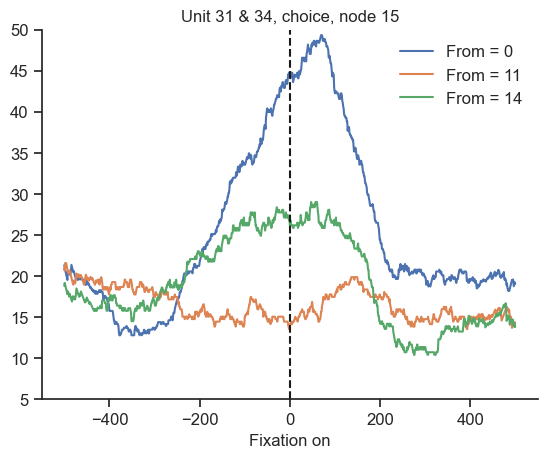

In [3229]:
plt.close('all')
prenodes = [0,11,14]
node = 15
t = np.arange(-500,500)

for ii in range(3):
    fix_idx = (fix_df.fix_node==node) & (fix_df.prenode==prenodes[ii]) & (fix_df.choice)
    trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='From = '+str(prenodes[ii]))

# fix_idx = (fix_df.fix_node==0) & (fix_df.choice)
# trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
# plt.plot(trace,color='k')
plt.legend(frameon=False)
plt.xlabel('Fixation on')
plt.plot([0,0],[5,50],'k--')
plt.ylim(5,50)
plt.title('Unit 31 & 34, choice, node '+str(node))
plt.savefig('Unit 31 & 34, choice, node '+str(node)+', From')

(-500.0, 500.0)

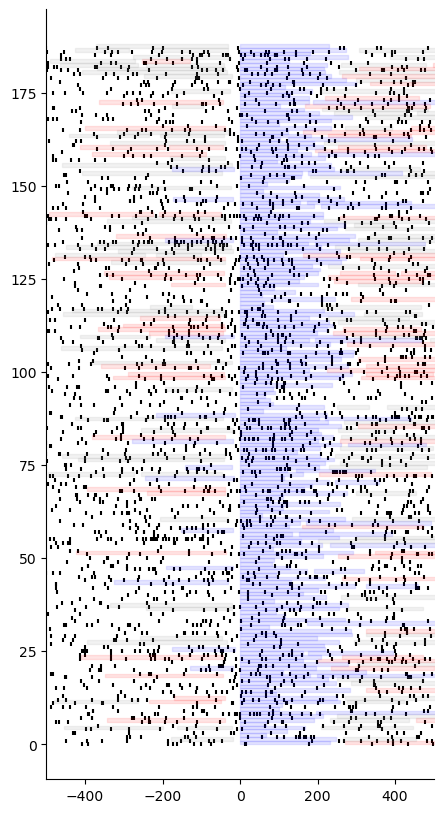

In [2273]:
# sort spikes by node

fix_idx = (fix_df.fix_node==15) & (fix_df.planning)

cell = 34
cell_spikes = (fix_spikes[fix_idx,:,31]+fix_spikes[fix_idx,:,34])>0

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(5,10))
plt.scatter(Y-500, X, marker = "|", c="k", s=5)
sns.despine()

choice_starts = fix_df[fix_idx].start_time.values
choice_stops = fix_df[fix_idx].stop_time.values

for ii in range(cell_spikes.shape[0]):
    
        choice_start = choice_starts[ii]
        choice_stop = choice_stops[ii]
        fixations_per_choice = fix_df[(fix_df.start_time>choice_start-500) & 
                                             (fix_df.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start 
        fixation_stops = fixations_per_choice.stop_time.values - choice_start 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            if fixation_nodes[jj] == 15:
                color = 'b'
            elif fixation_nodes[jj] == 0:
                color = 'r'
            else:
                color = 'gray'
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = color,alpha=0.1)


plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

Text(0.5, 1.0, 'Unit 31 & 34, choice fixate at node 14')

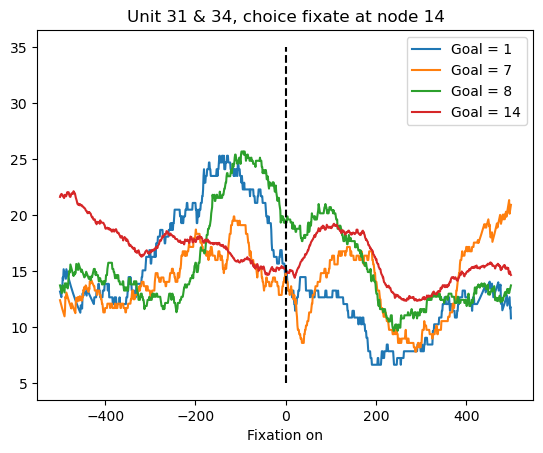

In [2369]:
plt.close('all')
node = 14
goals = [1,7,8,14]
t = np.arange(-500,500)

for ii in range(4):
    fix_idx = (fix_df.fix_node==node) & (fix_df.target==goals[ii]) & (fix_df.choice)
    trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='Goal = '+str(goals[ii]))

# fix_idx = (fix_df.fix_node==0) & (fix_df.choice)
# trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
# plt.plot(trace,color='k')
plt.plot([0,0],[5,35],'k--')
plt.legend()
plt.xlabel('Fixation on')
plt.title('Unit 31 & 34, choice fixate at node '+str(node))

Text(0.5, 0, 'Action on')

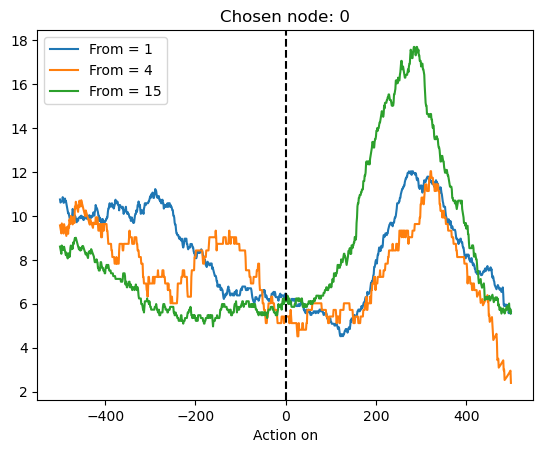

In [91]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 0
neighbors = [1,4,15]
cell = 60

plt.close('all')

t = np.arange(-500,500)

for ii,nn in enumerate(neighbors):
    fix_idx = (choice_df.node==node) & (choice_df.postnode==nn)
    trace = movmean(np.mean(choice_spikes[fix_idx,:,cell],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='From = '+str(nn))

plt.legend()
plt.title('Chosen node: '+str(node))
plt.axvline(color='k',linestyle='--')
# plt.ylim(5,45)
plt.xlabel('Action on')


In [44]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [ ]:
from matplotlib_venn import venn2

In [323]:
sig_neuron2

array([ 0,  2,  3,  4,  6, 13, 15, 16, 18, 19, 20, 31, 34, 44, 47, 48, 50,
       52, 56, 59, 60, 71, 72, 73, 79, 85])

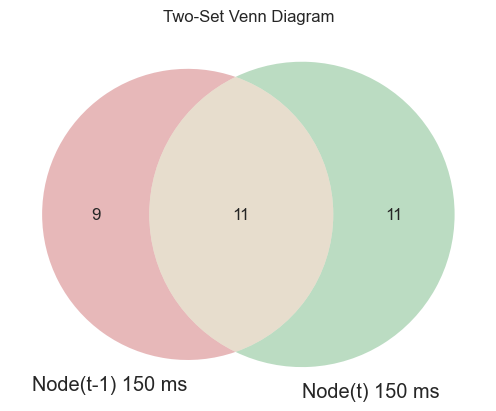

In [363]:
t1,sig_neuron1 = sig_neuron(sig_pre,[11])
t2,sig_neuron2 = sig_neuron(sig,[11])

# Example for two sets
AB = len(np.intersect1d(sig_neuron1, sig_neuron2))
venn2(subsets=(len(sig_neuron1)-AB, len(sig_neuron2)-AB, AB), set_labels=('Node(t-1) %i ms'%timestamps[t1], 
                                                                   'Node(t) %i ms'%timestamps[t2]))
plt.title("Two-Set Venn Diagram")
plt.show()

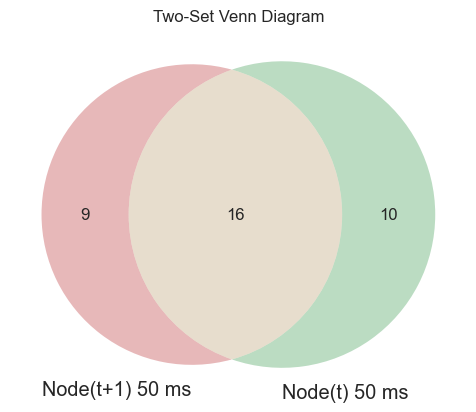

In [357]:
t1,sig_neuron1 = sig_neuron(sig_post)
t2,sig_neuron2 = sig_neuron(sig)

# Example for two sets
AB = len(np.intersect1d(sig_neuron1, sig_neuron2))
venn2(subsets=(len(sig_neuron1)-AB, len(sig_neuron2)-AB, AB), set_labels=('Node(t+1) %i ms'%timestamps[t1], 
                                                                   'Node(t) %i ms'%timestamps[t2]))
plt.title("Two-Set Venn Diagram")
plt.show()

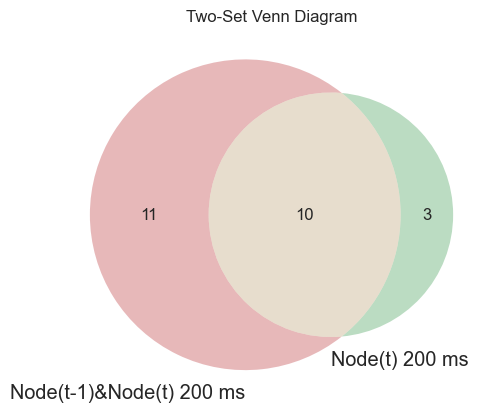

In [347]:
t1,sig_neuron1 = sig_neuron(sig_pre,[12])
t2,sig_neuron2 = sig_neuron(sig,[12])

# Example for two sets
AB = len(np.intersect1d(sig_neuron1, sig_neuron2))
venn2(subsets=(len(sig_neuron1)-AB, len(sig_neuron2)-AB, AB), set_labels=('Node(t-1)&Node(t) %i ms'%timestamps[t1], 
                                                                   'Node(t) %i ms'%timestamps[t2]))
plt.title("Two-Set Venn Diagram")
plt.show()

In [335]:
score_pre, sig_pre, Lambda_all_pre, Lambda_i_pre, _ = np.load('IC pre current.npz').values()

In [299]:
score_pre, sig_pre, Lambda_all_pre, Lambda_i_pre, _ = np.load('IC pre.npz').values()

In [355]:
score_post, sig_post, Lambda_all_post, Lambda_i_post, _ = np.load('IC current post.npz').values()

In [307]:
def sig_neuron(sig,t=[]):

    if len(t)==0:
        t = np.argmax(sig.mean(axis=0))
    else:
        t = t[0]
    ind = np.where(sig[:,t])[0]
    # ind = np.argsort(score[:,t_max]) 
    # node_dis = np.argmax(Lambda_i[neuron_idx,t_max,:],axis=1)

    return t,ind

Text(0.5, 0, 'Preferred node')

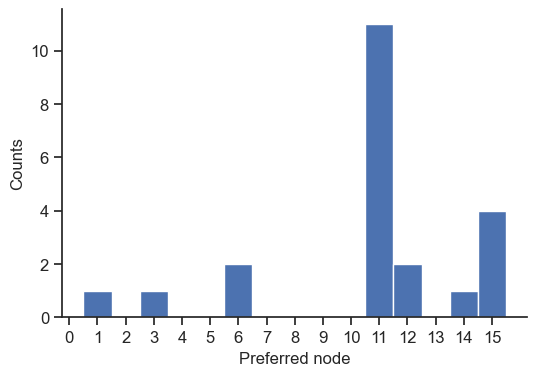

In [325]:
plt.close('all')
plt.figure(figsize=(6,4))

t_max = np.argmax(sig.mean(axis=0))
ind = np.argsort(score[:,t_max]) 
node_dis1 = np.argmax(Lambda_i[neuron_idx,t_max,:],axis=1)

plt.hist(node_dis1,bins=np.arange(0.5,16,1))

# ind = np.argsort(score[:,-2]) 
# node_dis2 = np.argmax(Lambda_i[neuron_idx,-1,:],axis=1)

# plt.hist([node_dis1,node_dis2],bins=np.arange(0.5,16,1))


plt.xticks(np.arange(16))
plt.ylabel('Counts')
plt.xlabel('Preferred node')

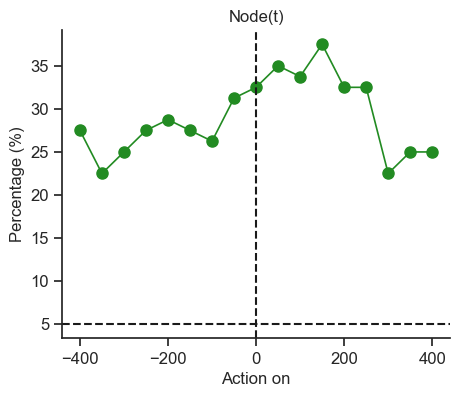

In [383]:
score, sig, Lambda_all, Lambda_i, null = np.load('031723 IC prenode.npz').values()

criterion1 = score > np.percentile(null, 99,axis=1)
criterion2 = Lambda_all > 1
criterion3 = score > 0.01
sig = criterion1*criterion2*criterion3

timestamps = np.arange(100,950,50)-500
plt.close('all')
plt.figure(figsize=(5,4))
plt.plot(timestamps,sig.mean(axis=0)*100,color='forestgreen',lw=1.2,marker='o',ms=8)
plt.axvline(c='k',ls='--')
plt.title('Node(t)')
plt.ylabel('Percentage (%)')
plt.xlabel('Action on')
plt.axhline(5,color='k',linestyle='--')

Text(0.5, 0, 'Action on')

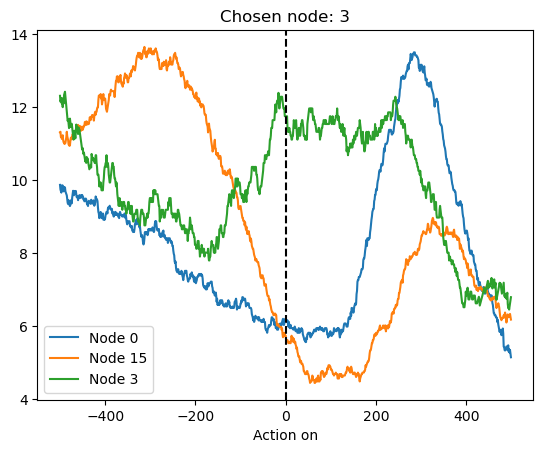

In [83]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 3
neighbors = [2,7]
cell = 60

plt.close('all')

t = np.arange(-500,500)

fix_idx = (choice_df.node==0)
trace = movmean(np.mean(choice_spikes[fix_idx,:,cell],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,label='Node 0')

fix_idx = (choice_df.node==15)
trace = movmean(np.mean(choice_spikes[fix_idx,:,cell],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,label='Node 15')

fix_idx = (choice_df.node==3)
trace = movmean(np.mean(choice_spikes[fix_idx,:,cell],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,label='Node 3')

plt.legend()
plt.title('Chosen node: '+str(node))
plt.axvline(color='k',linestyle='--')
# plt.ylim(5,45)
plt.xlabel('Action on')


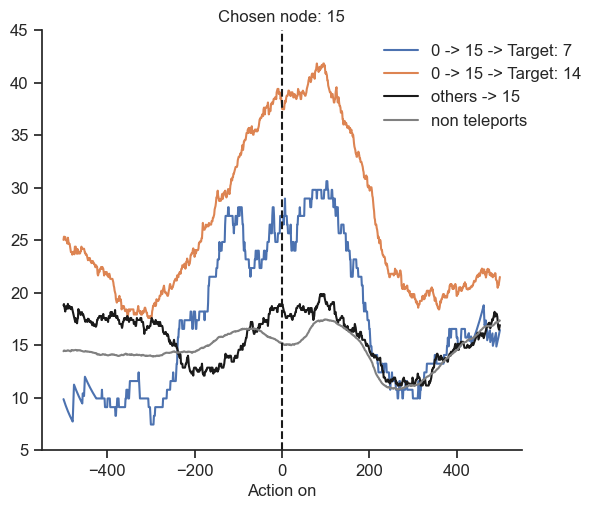

In [3245]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 15
goals = [7,14]


plt.close('all')
plt.figure(figsize=(8,6))
t = np.arange(-500,500)

for ii,nn in enumerate(goals):
    fix_idx = (choice_df.node==node) & (choice_df.prenode==0) & (choice_df.target==nn)
    trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='0 -> 15 -> Target: '+str(nn))

fix_idx = (choice_df.node==node) & (choice_df.prenode>0) 
trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='k',label='others -> 15 ')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

fix_idx = (choice_df.node!=0) & (choice_df.node!=15) 
trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='gray',label='non teleports')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

plt.legend(loc=(0.7,0.75),frameon=False)
plt.title('Chosen node: '+str(node))
plt.plot([0,0],[5,45],'k--')
plt.ylim(5,45)
plt.xlabel('Action on')
plt.savefig('Unit 31 & 34, choice, node '+str(node)+', From & target')

Text(0.5, 0, 'Action on')

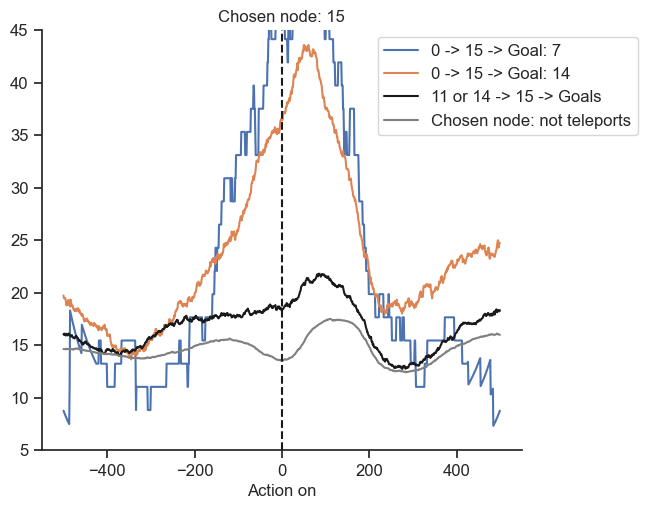

In [3237]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 15
goals = [7,14]


plt.close('all')
plt.figure(figsize=(8,6))
t = np.arange(-500,500)

for ii,nn in enumerate(goals):
    fix_idx = (fix_df.fix_node==node) & (fix_df.prenode==0) & (fix_df.target==nn)
    trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='0 -> 15 -> Goal: '+str(nn))

fix_idx = (fix_df.fix_node==node) & (fix_df.prenode>0) 
trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='k',label='11 or 14 -> 15 -> Goals')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

fix_idx = (fix_df.fix_node!=0) & (fix_df.fix_node!=15) 
trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='gray',label='Chosen node: not teleports')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

plt.legend(loc=(0.7,0.75))
plt.title('Chosen node: '+str(node))
plt.plot([0,0],[5,45],'k--')
plt.ylim(5,45)
plt.xlabel('Action on')


Text(0.5, 0, 'Planning fixations on')

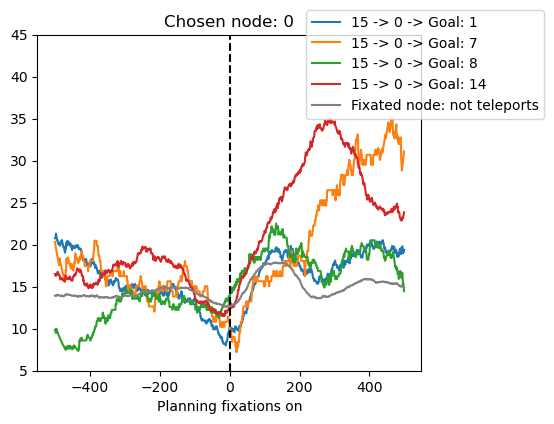

In [2923]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 0
goals = [1,7,8,14]


# plt.close('all')
# plt.figure(figsize=(8,6))
t = np.arange(-500,500)

for ii,nn in enumerate(goals):
    fix_idx = (fix_df.fix_node==node) &  (fix_df.target==nn) & (fix_df.planning)
    trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='15 -> 0 -> Goal: '+str(nn))

# fix_idx = (fix_df.fix_node==node) & (fix_df.prenode!=15) & (fix_df.planning)
# trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
# plt.plot(t,trace,color='k',label='1 or 4 -> 0 -> Goals')
# ax = plt.gca()
# ax.set_position([0.15,0.15,0.6,0.7])

fix_idx = (fix_df.fix_node!=0) & (fix_df.fix_node!=15) & (fix_df.planning)
trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='gray',label='Fixated node: not teleports')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

plt.legend(loc=(0.7,0.75))
plt.title('Chosen node: '+str(node))
plt.plot([0,0],[5,45],'k--')
plt.ylim(5,45)
plt.xlabel('Planning fixations on')


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Text(0.5, 1.0, 'Unit 31 & 34, NOT use tele, at node 0')

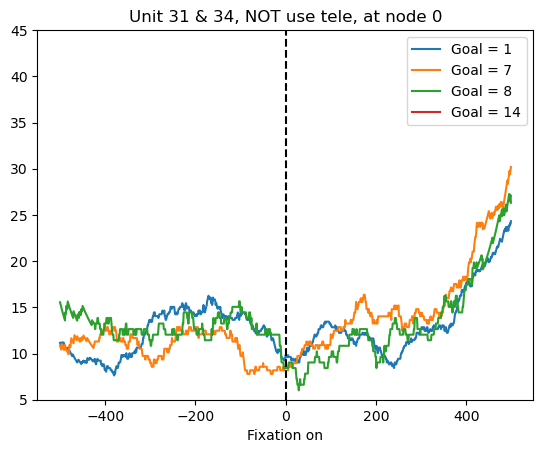

In [2395]:
plt.close('all')
node = 0
goals = [1,7,8,14]
t = np.arange(-500,500)

for ii in range(4):
    fix_idx = (choice_df.node==node) & (choice_df.target==goals[ii]) & (~choice_df.use_tele)
    trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='Goal = '+str(goals[ii]))

# fix_idx = (fix_df.fix_node==0) & (fix_df.choice)
# trace = movmean(np.mean(fix_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
# plt.plot(trace,color='k')
plt.plot([0,0],[5,45],'k--')
plt.legend()
plt.ylim(5,45)
plt.xlabel('Fixation on')
plt.title('Unit 31 & 34, NOT use tele, at node '+str(node))

In [3906]:
clf = SVC(kernel='linear',probability=True)

In [130]:
# half-split, 16 way classification

# binary decoder, half split, balanced trial number between node v.s. non-node

rep = 20
ntrials = 200
w = 100
slide = 20

# chosen_accuracy = np.zeros((rep,choice_spikes.shape[1]))
kf = KFold(n_splits=2, shuffle=True)
clf = SVC(kernel='linear',probability=True)

chosen_accuracy = np.zeros((rep,int((1000-2*w)/slide)))
cfs_mtx = np.zeros((rep,int((1000-2*w)/slide),16,16))


for rr in tqdm(range(rep)):

    bootstrapped = np.zeros((2,16,ntrials,FR.shape[1],choice_spikes.shape[2]+1))
    # col 1: train v.s. test

    for node in range(16):

        conditioned_beh = choice_df[choice_df.node==node]
        trialNum = np.array(conditioned_beh.index)
        
        for ii, split_ind in enumerate(list(kf.split(trialNum))[0]):
        
            split_set = conditioned_beh.iloc[split_ind]
            index = np.random.randint(len(split_set),size=ntrials)
            bootstrapped[ii,node,:,:,:-1] = np.stack(split_set.iloc[index]['Neural'].values)
            bootstrapped[ii,node,:,:,-1] = node
        
    
    for ii,t in enumerate(range(w,1000-w,slide)): #range(choice_spikes.shape[1]):
        
        train = bootstrapped[0,:,:,t-w:t+w,:].mean(axis=2).reshape(-1,choice_spikes.shape[2]+1)
        test = bootstrapped[1,:,:,t-w:t+w,:].mean(axis=2).reshape(-1,choice_spikes.shape[2]+1)
        clf.fit(train[:,:-1],train[:,-1])
        chosen_accuracy[rr,ii] = accuracy_score(test[:,-1],clf.predict(test[:,:-1]))
        cfs_mtx[rr,ii,:,:] = confusion_matrix(test[:,-1],clf.predict(test[:,:-1]),labels=np.arange(16))


100%|████████████████████████████████████████| 20/20 [1:23:15<00:00, 249.77s/it]


In [12]:
DATA_DIR = Path('/Volumes/Extreme SSD')
choice_df_all, choice_spikes_all, neuron_df = combine_data(DATA_DIR,"HPC","action_on","trialerror == 0",'last')

Building Spike Table


1499it [00:01, 1266.92it/s]


Building Spike Table


1860it [00:01, 1142.77it/s]


Building Spike Table


2067it [00:01, 1153.08it/s]


In [2]:
choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,"HPC","action_on","(trialerror == 0) & (step==0)")

NameError: name 'combine_data' is not defined

In [13]:
ses = 0
choice_df = choice_df_all.query('Session==@ses').copy()
choice_spikes = choice_spikes_all[ses]

In [14]:
FR = choice_spikes.copy()

FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(choice_spikes.shape[0],choice_spikes.shape[1],1)))/ \
     np.tile(FR.std(axis=(0,1),keepdims=True),(choice_spikes.shape[0],choice_spikes.shape[1],1))

choice_df['Neural']=list(FR)

In [18]:
# 5-fold, 16 way classification

# binary decoder, half split, balanced trial number between node v.s. non-node

rep = 10
ntrials = 200
w = 100
slide = 50

# chosen_accuracy = np.zeros((rep,choice_spikes.shape[1]))
kf = KFold(n_splits=3, shuffle=True)
clf = SVC(kernel='linear',probability=True)

chosen_accuracy = np.zeros((rep,int((1000-2*w)/slide)))
cfs_mtx = np.zeros((rep,int((1000-2*w)/slide),16,16))


for rr in tqdm(range(rep)):

    train_all = np.zeros((16,ntrials,FR.shape[1],choice_spikes.shape[2]+1))
    test_all = np.zeros((16,ntrials,FR.shape[1],choice_spikes.shape[2]+1))

    for node in range(16):

        conditioned_beh = choice_df[choice_df.node==node]
        trialNum = np.array(conditioned_beh.index)
        train_ind, test_ind = list(kf.split(trialNum))[0]
        
        train_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(train_set),size=ntrials)
        train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
        train_all[node,:,:,-1] = node

        test_set = conditioned_beh.iloc[test_ind]
        index = np.random.randint(len(test_set),size=ntrials)
        test_all[node,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
        test_all[node,:,:,-1] = node

        # temp = np.zeros((len(test_ind),FR.shape[1],choice_spikes.shape[2]+1))
        # temp[:,:,:-1] = np.stack(conditioned_beh.iloc[test_ind]['Neural'].values)
        # temp[:,:,-1] = node
        # if node==0:
        #     test_all = temp
        # else:
        #     test_all = np.concatenate((test,temp))
        
    train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,choice_spikes.shape[2]+1)
    clf.fit(train[:,:-1],train[:,-1])
    
    for ii,t in enumerate(range(w,1000-w,slide)): #range(choice_spikes.shape[1]):
        
        test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,choice_spikes.shape[2]+1)
        chosen_accuracy[rr,ii] = accuracy_score(test[:,-1],clf.predict(test[:,:-1]))
        cfs_mtx[rr,ii,:,:] = confusion_matrix(test[:,-1],clf.predict(test[:,:-1]),labels=np.arange(16))


  0%|                                                    | 0/10 [00:00<?, ?it/s]


ValueError: Cannot have number of splits n_splits=3 greater than the number of samples: n_samples=0.

In [36]:
# 5-fold, 4 way classification, last step -> goal

# binary decoder, half split, balanced trial number between node v.s. non-node

rep = 10
ntrials = 200
w = 100
slide = 50

# chosen_accuracy = np.zeros((rep,choice_spikes.shape[1]))
kf = KFold(n_splits=3, shuffle=True)
clf = SVC(kernel='linear',probability=True)

chosen_accuracy = np.zeros((rep,int((1000-2*w)/slide)))
cfs_mtx = np.zeros((rep,int((1000-2*w)/slide),4,4))


for rr in tqdm(range(rep)):

    train_all = np.zeros((4,ntrials,FR.shape[1],choice_spikes.shape[2]+1))
    test_all = np.zeros((4,ntrials,FR.shape[1],choice_spikes.shape[2]+1))

    for ii, node in enumerate([1,7,8,14]):

        conditioned_beh = choice_df[choice_df.node==node]
        trialNum = np.array(conditioned_beh.index)
        train_ind, test_ind = list(kf.split(trialNum))[0]
        
        train_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(train_set),size=ntrials)
        train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
        train_all[ii,:,:,-1] = node

        test_set = conditioned_beh.iloc[test_ind]
        index = np.random.randint(len(test_set),size=ntrials)
        test_all[ii,:,:,:-1] = np.stack(test_set.iloc[index]['Neural'].values)
        test_all[ii,:,:,-1] = node

        # temp = np.zeros((len(test_ind),FR.shape[1],choice_spikes.shape[2]+1))
        # temp[:,:,:-1] = np.stack(conditioned_beh.iloc[test_ind]['Neural'].values)
        # temp[:,:,-1] = node
        # if node==0:
        #     test_all = temp
        # else:
        #     test_all = np.concatenate((test,temp))
        
    train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,choice_spikes.shape[2]+1)
    clf.fit(train[:,:-1],train[:,-1])
    
    for ii,t in enumerate(range(w,1000-w,slide)): #range(choice_spikes.shape[1]):
        
        test = test_all[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,choice_spikes.shape[2]+1)
        chosen_accuracy[rr,ii] = accuracy_score(test[:,-1],clf.predict(test[:,:-1]))
        cfs_mtx[rr,ii,:,:] = confusion_matrix(test[:,-1],clf.predict(test[:,:-1]),labels=[1,7,8,14])


100%|███████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


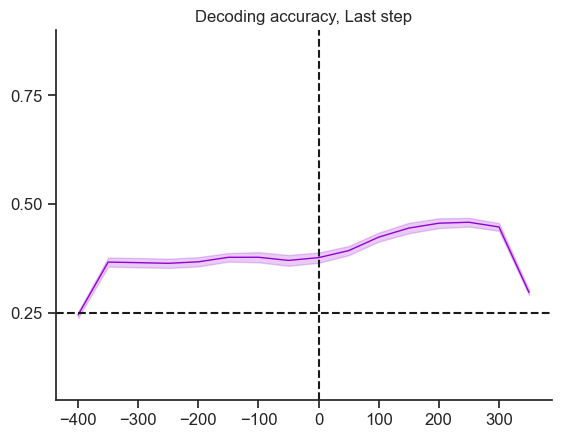

In [46]:
node_acc = chosen_accuracy
mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
time = np.arange(w,1000-w,slide)-500

plt.close('all')
plt.plot(time,mean,color='darkviolet',lw=1)
plt.fill_between(time,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
plt.axvline(c='k',ls='--')
plt.axhline(y=1/4,c='k',ls='--')
plt.ylim(0.05,0.9)
plt.yticks(np.arange(0.25,1,0.25))
plt.title('Decoding accuracy, Last step')
plt.savefig('Decoding accuracy, Last step, Session %i' % ses)

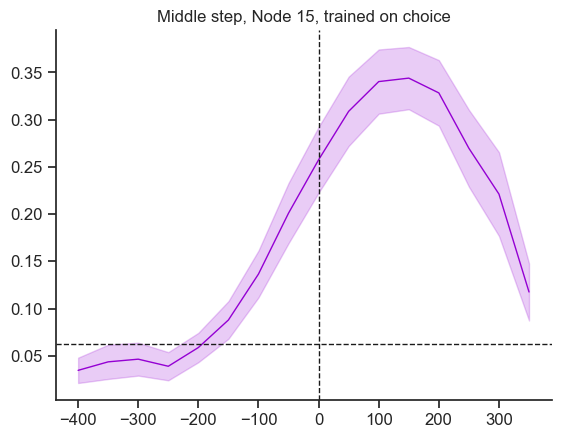

In [61]:
for node in range(16):
    
    node_acc = cfs_mtx[:,:,node,node]/200
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    time = np.arange(w,1000-w,slide)-500

    plt.close('all')
    plt.plot(time,mean,color='darkviolet',lw=1)
    plt.fill_between(time,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
    plt.axvline(c='k',ls='--')
    plt.axhline(y=1/16,c='k',ls='--')
    plt.title('Middle step, Node %i, trained on choice'%node)
    plt.savefig('Session %i, middle step, 5-fold trained on choice period, Decoding Node %i' % (ses,node))

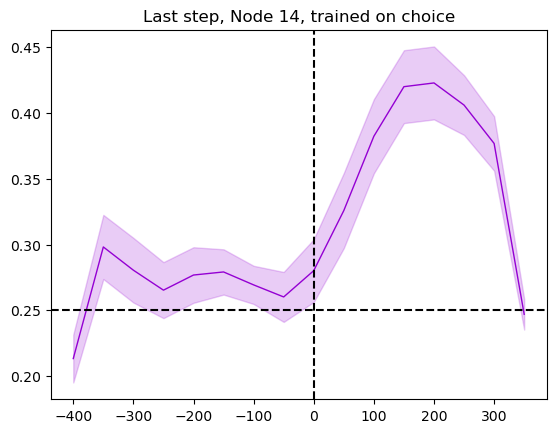

In [42]:
for ii, node in enumerate([1,7,8,14]):
    
    node_acc = cfs_mtx[:,:,ii,ii]/200
    mean = np.convolve(node_acc.mean(axis=0),np.ones(3)/3,'same')
    sem = np.convolve(node_acc.std(axis=0)/np.sqrt(node_acc.shape[0]),np.ones(3)/3,'same')
    time = np.arange(w,1000-w,slide)-500

    plt.close('all')
    plt.plot(time,mean,color='darkviolet',lw=1)
    plt.fill_between(time,mean-sem,mean+sem,color='darkviolet',alpha=0.2)
    plt.axvline(c='k',ls='--')
    plt.axhline(y=1/4,c='k',ls='--')
    plt.title('Last step, Node %i, trained on choice'%node)
    plt.savefig('Session %i, last step, 5-fold trained on choice period, Decoding Node %i' % (ses,node))

In [3726]:
# 16-way classifier decoder, leave one out, 

ntrials = 1000
clf = SVC(kernel='linear',probability=True)
w=100
chosen_accuracy=np.zeros((len(choice_df),int(1000/w)-1))
all_label = choice_df.node.values


for node in [0]: #range(16):

    for trial in tqdm(range(len(choice_df))):

        FR = np.delete(choice_spikes,trial,axis=0)
        labels = np.delete(choice_df.node.values,trial)

        for ii,t in enumerate(range(w,1000,w)): #range(choice_spikes.shape[1]):
            clf.fit(FR[:,t-w:t+w,:].mean(axis=1),labels)
            chosen_accuracy[trial,ii] = accuracy_score([labels[trial]],
                                                    clf.predict(choice_spikes[trial,t-w:t+w,:].mean(axis=0,keepdims=True)))
        
    plt.close('all')
    plt.plot(np.arange(w,1000,w)-500,chosen_accuracy.mean(axis=0))
    plt.plot([-500,500],[0.5,0.5],'k--')
    plt.plot([0,0],[0,1],'k--')
    plt.ylim(0,1)
    plt.title('Node: '+str(node))
    # plt.savefig('Decoding node '+str(node))

 14%|████▊                              | 286/2067 [1:46:15<11:01:42, 22.29s/it]


KeyboardInterrupt: 

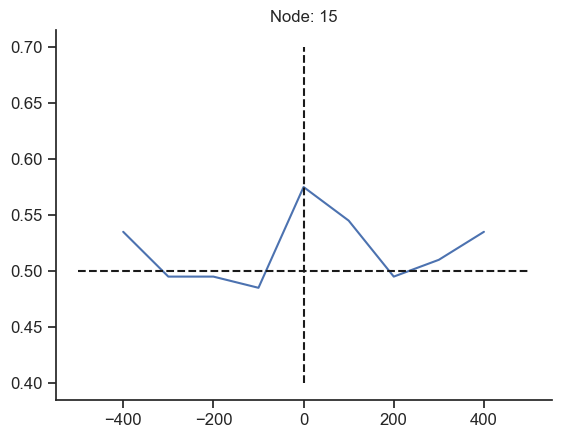

In [3504]:
# binary decoder, half split, balanced trial number between node v.s. non-node

rep = 1
ntrials = 100

# chosen_accuracy = np.zeros((rep,choice_spikes.shape[1]))
kf = KFold(n_splits=2, shuffle=True)
clf = SVC(kernel='linear')


for node in range(16):

# for rr in range(rep):


    train_X = np.zeros((2,ntrials,choice_spikes.shape[1],choice_spikes.shape[2]))
    train_noX = np.zeros((2,ntrials,choice_spikes.shape[1],choice_spikes.shape[2]))

    conditioned_beh = choice_df[choice_df.node==node]
    trialNum = np.array(conditioned_beh.index)
    
    for ii, train_ind in enumerate(list(kf.split(trialNum))[0]):
    
        split_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(split_set),size=ntrials)
        train_X[ii,:,:] = np.stack(split_set.iloc[index]['Neural'].values)

    
    conditioned_beh = choice_df[choice_df.node!=node]
    trialNum = np.array(conditioned_beh.index)
    
    for ii, train_ind in enumerate(list(kf.split(trialNum))[0]):
    
        split_set = conditioned_beh.iloc[train_ind]
        index = np.random.randint(len(split_set),size=ntrials)
        train_noX[ii,:,:] = np.stack(split_set.iloc[index]['Neural'].values)
        

    w=100
    chosen_accuracy=np.zeros(int(1000/w)-1)
    
    for ii,t in enumerate(range(w,1000,w)):#range(choice_spikes.shape[1]):
        clf.fit(np.concatenate((train_X[0,:,t-w:t+w,:].mean(axis=1),
                                train_noX[0,:,t-w:t+w,:].mean(axis=1))),
                np.concatenate((np.ones(ntrials),np.zeros(ntrials))))
        chosen_accuracy[ii] = balanced_accuracy_score(np.concatenate((np.ones(ntrials),np.zeros(ntrials))),
                                                        clf.predict(np.concatenate((train_X[1,:,t-w:t+w,:].mean(axis=1),
                                                        train_noX[1,:,t-w:t+w,:].mean(axis=1)))))
    
    plt.close('all')
    plt.plot(np.arange(w,1000,w)-500,chosen_accuracy)
    plt.plot([-500,500],[0.5,0.5],'k--')
    plt.plot([0,0],[0.4,0.7],'k--')
    plt.title('Node: '+str(node))
    plt.savefig('decoding node '+str(node))

In [ ]:
# 0->15

# find all transitions to node 15, from its direct neighbors
node = 15
goals = [7,14]


plt.close('all')
plt.figure(figsize=(8,6))
t = np.arange(-500,500)

for ii,nn in enumerate(goals):
    fix_idx = (choice_df.node==node) & (choice_df.prenode==0) & (choice_df.target==nn)
    trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
    plt.plot(t,trace,label='0 -> 15 -> Goal: '+str(nn))

fix_idx = (choice_df.node==node) & (choice_df.prenode>0) 
trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='k',label='11 or 14 -> 15 -> Goals')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

fix_idx = (choice_df.node!=0) & (choice_df.node!=15) 
trace = movmean(np.mean(choice_spikes[fix_idx,:,88],axis=0)*1000, w=75).flatten()
plt.plot(t,trace,color='gray',label='Chosen node: not teleports')
ax = plt.gca()
ax.set_position([0.15,0.15,0.6,0.7])

plt.legend(loc=(0.7,0.75))
plt.title('Chosen node: '+str(node))
plt.plot([0,0],[5,45],'k--')
plt.ylim(5,45)
plt.xlabel('Action on')


(-500.0, 500.0)

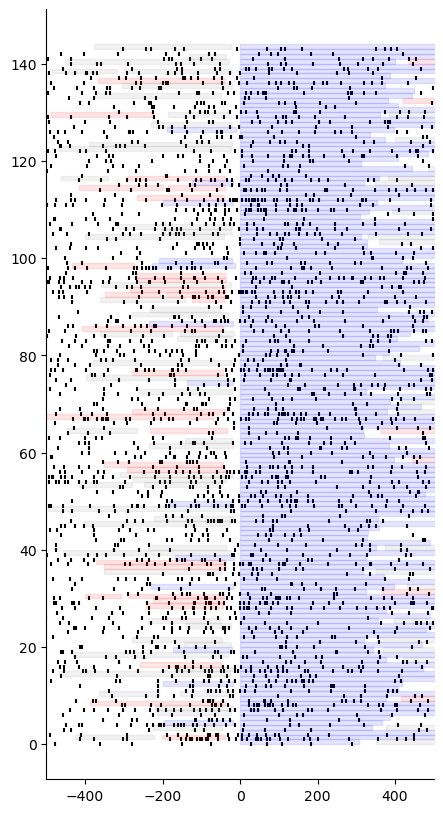

In [2579]:
# sort spikes by node

fix_idx = (fix_df.fix_node==15) & (fix_df.choice)

cell_spikes = (fix_spikes[fix_idx,:,31]+fix_spikes[fix_idx,:,34])>0

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(5,10))
plt.scatter(Y-500, X, marker = "|", c="k", s=5)
sns.despine()

choice_starts = fix_df[fix_idx].start_time.values
choice_stops = fix_df[fix_idx].stop_time.values

for ii in range(cell_spikes.shape[0]):
    
        choice_start = choice_starts[ii]
        choice_stop = choice_stops[ii]
        fixations_per_choice = fix_df[(fix_df.start_time>choice_start-500) & 
                                             (fix_df.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start 
        fixation_stops = fixations_per_choice.stop_time.values - choice_start 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            if fixation_nodes[jj] == 15:
                color = 'b'
            elif fixation_nodes[jj] == 0:
                color = 'r'
            else:
                color = 'gray'
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = color,alpha=0.1)


plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

In [201]:
choice_spikes.shape, choice_df.shape, unitNames.shape

((2067, 1000, 88), (2067, 18), (88, 24))

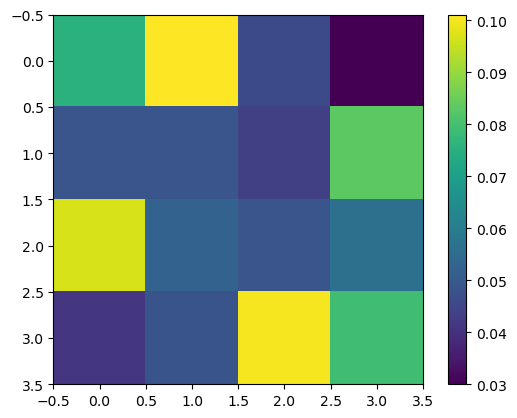

In [197]:
plt.imshow(choice_df['node'].value_counts(normalize=True).sort_index().values.reshape(4,4))
plt.colorbar()

In [617]:
# Pi = probability of occupying a given node
# lamda_i = mean FR for a given node
# lamda = mean FR across all nodes

def information_score(cell,labels,timestamps,w=100):

    """
    timestamps: center of the window
    w: 1/2 width of the window
    """

    Pi = np.array([np.mean(labels==g) for g in np.arange(16)])
    IC = np.zeros(len(timestamps))
    FRpass = np.zeros(len(timestamps))
    ICpass = np.zeros(len(timestamps))

    for ii, ts in enumerate(timestamps):
        
        lamda = choice_spikes[:, ts-w:ts+w, cell].mean(axis=(0, 1))*1000
        lamda_i = np.array([choice_spikes[labels == g, ts-w:ts+w, cell].mean() 
                  for g in np.arange(16)])*1000
        IC[ii] = np.sum(Pi*lamda_i*np.log2(lamda_i/lamda))

        if lamda > 1:
            FRpass[ii] = 1
        else:
            FRpass[ii] = 0
            
        if IC[ii] > 0.2:
            ICpass[ii] = 1
        else:
            ICpass[ii] = 0

    
    return IC, FRpass, ICpass

In [619]:
def shuffle_node(cell,labels,timestamps,n=1000):

    null = np.zeros((n,len(timestamps)))

    for i in tqdm(range(n)):
        shuffled_label = np.random.permutation(labels)
        null[i,:],_,_ = information_score(cell,shuffled_label,timestamps)

    return null

In [637]:
data_labels = choice_df['node'].values
timestamps = np.arange(100,1000,100)

N_cell = choice_spikes.shape[2] # number of cells
N_shuffle = 1000
N_ts = len(timestamps)

score = np.zeros((N_cell,N_ts))
FRpass = np.zeros((N_cell,N_ts))
ICpass = np.zeros((N_cell,N_ts))
null = np.zeros((N_cell,N_shuffle,N_ts))
sig = np.zeros((N_cell,N_ts))

for cell in range(N_cell):

    print('Neuron #', cell)

    score[cell,:],FRpass[cell,:], ICpass[cell,:] = information_score(cell,data_labels,timestamps)
    null[cell,:,:] = shuffle_node(cell,data_labels,timestamps, n = N_shuffle)

    sig[cell,:] = score[cell,:] > np.percentile(null[cell,:,:], 95,axis=0)

Neuron # 0


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.54it/s]


Neuron # 1


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.49it/s]


Neuron # 2


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.57it/s]


Neuron # 3


100%|███████████████████████████████████████| 1000/1000 [00:59<00:00, 16.86it/s]


Neuron # 4


100%|███████████████████████████████████████| 1000/1000 [00:59<00:00, 16.86it/s]


Neuron # 5


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.38it/s]


Neuron # 6


100%|███████████████████████████████████████| 1000/1000 [00:59<00:00, 16.77it/s]


Neuron # 7


100%|███████████████████████████████████████| 1000/1000 [00:58<00:00, 16.95it/s]


Neuron # 8


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.50it/s]


Neuron # 9


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.25it/s]


Neuron # 10


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.56it/s]


Neuron # 11


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.49it/s]


Neuron # 12


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.18it/s]


Neuron # 13


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.31it/s]


Neuron # 14


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.23it/s]


Neuron # 15


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.06it/s]


Neuron # 16


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.29it/s]


Neuron # 17


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.43it/s]


Neuron # 18


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.41it/s]


Neuron # 19


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.49it/s]


Neuron # 20


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.49it/s]


Neuron # 21


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.29it/s]


Neuron # 22


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.31it/s]


Neuron # 23


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.21it/s]


Neuron # 24


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.96it/s]


Neuron # 25


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.10it/s]


Neuron # 26


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.93it/s]


Neuron # 27


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.21it/s]


Neuron # 28


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.15it/s]


Neuron # 29


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.31it/s]


Neuron # 30


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.33it/s]


Neuron # 31


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.13it/s]


Neuron # 32


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.21it/s]


Neuron # 33


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.99it/s]


Neuron # 34


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.55it/s]


Neuron # 35


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.39it/s]


Neuron # 36


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.36it/s]


Neuron # 37


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.48it/s]


Neuron # 38


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.29it/s]


Neuron # 39


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.64it/s]


Neuron # 40


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.56it/s]


Neuron # 41


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.62it/s]


Neuron # 42


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.35it/s]


Neuron # 43


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.42it/s]


Neuron # 44


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.32it/s]


Neuron # 45


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.25it/s]


Neuron # 46


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.31it/s]


Neuron # 47


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.06it/s]


Neuron # 48


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.52it/s]


Neuron # 49


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.10it/s]


Neuron # 50


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.33it/s]


Neuron # 51


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.14it/s]


Neuron # 52


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.99it/s]


Neuron # 53


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.28it/s]


Neuron # 54


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.04it/s]


Neuron # 55


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.87it/s]


Neuron # 56


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.03it/s]


Neuron # 57


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.09it/s]


Neuron # 58


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.16it/s]


Neuron # 59


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.06it/s]


Neuron # 60


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.95it/s]


Neuron # 61


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.05it/s]


Neuron # 62


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.99it/s]


Neuron # 63


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.11it/s]


Neuron # 64


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.19it/s]


Neuron # 65


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.17it/s]


Neuron # 66


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.44it/s]


Neuron # 67


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.73it/s]


Neuron # 68


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.74it/s]


Neuron # 69


100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 15.14it/s]


Neuron # 70


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.26it/s]


Neuron # 71


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.28it/s]


Neuron # 72


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.52it/s]


Neuron # 73


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.85it/s]


Neuron # 74


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.63it/s]


Neuron # 75


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.54it/s]


Neuron # 76


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.40it/s]


Neuron # 77


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.33it/s]


Neuron # 78


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.27it/s]


Neuron # 79


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.34it/s]


Neuron # 80


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.83it/s]


Neuron # 81


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.75it/s]


Neuron # 82


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.01it/s]


Neuron # 83


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.09it/s]


Neuron # 84


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.54it/s]


Neuron # 85


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.36it/s]


Neuron # 86


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.54it/s]


Neuron # 87


100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.37it/s]


In [667]:
np.savez('IC.npz', score, FRpass, null, sig)

In [675]:
# sort cells according to IC
t_max = np.argmax(sig.mean(axis=0))
ind = np.argsort(score[:,t_max])

5

In [903]:
colors = sns.color_palette('Set1',16)

(-500.0, 500.0)

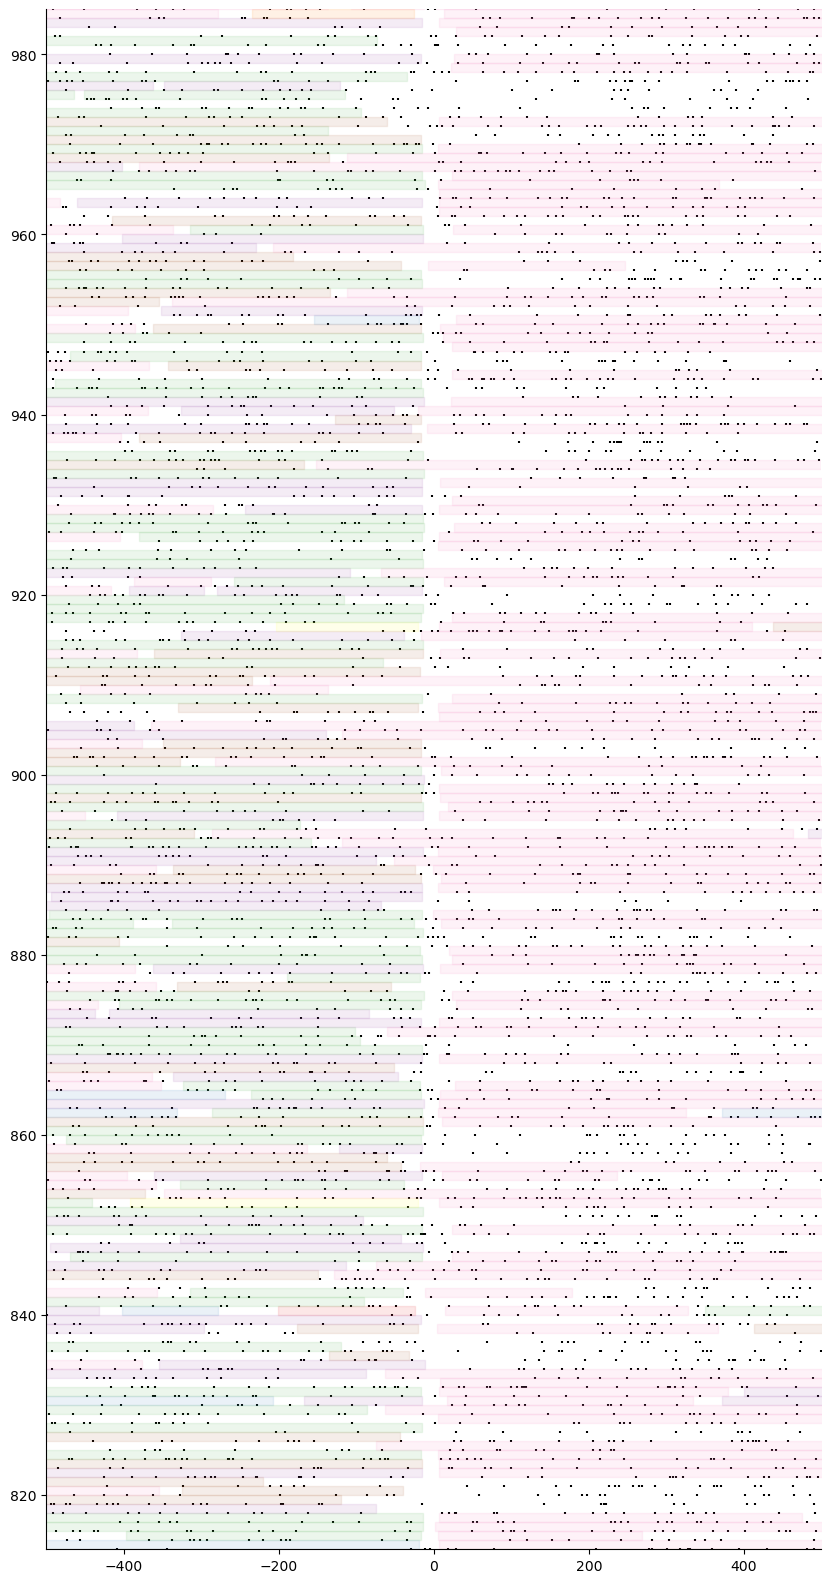

In [1031]:
# sort spikes by node
node_sorted = np.sort(choice_df.node.values)
node_ind = np.argsort(choice_df.node.values)
choice_spikes_sorted = choice_spikes[node_ind,:,:]

cell=1
cell_spikes = choice_spikes_sorted[:,:,cell]

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(10,20))
plt.scatter(Y-500, X, marker = "|", c="k", s=1)
# ax[1].set_xlim(spikes.timestamps[0], spikes.timestamps[-1])
# ax[1].set_ylabel("Neuron #")
# ax[1].set_xlabel("Time in session (ms)")
sns.despine()

# for nn in range(16):
#     y = np.where(node_sorted==nn)[0]
#     plt.fill_between([-500,500],y[0],y[-1],color=colors[nn],alpha=0.1)

choice_starts = choice_df.start_time.values
choice_stops = choice_df.stop_time.values

for ii in range(choice_spikes.shape[0]):
    
        n_choice = node_ind[ii]
        choice_start = choice_starts[n_choice]
        choice_stop = choice_stops[n_choice]
        fixations_per_choice = all_fixations[(all_fixations.start_time>choice_start-500) & 
                                             (all_fixations.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start - 500
        fixation_stops = fixations_per_choice.stop_time.values - choice_start - 500
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = colors[fixation_nodes[jj]],alpha=0.1)


y11 = np.where(node_sorted==7)[0]
plt.ylim(y11[0],y11[-1])
plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

(1395.0, 1510.0)

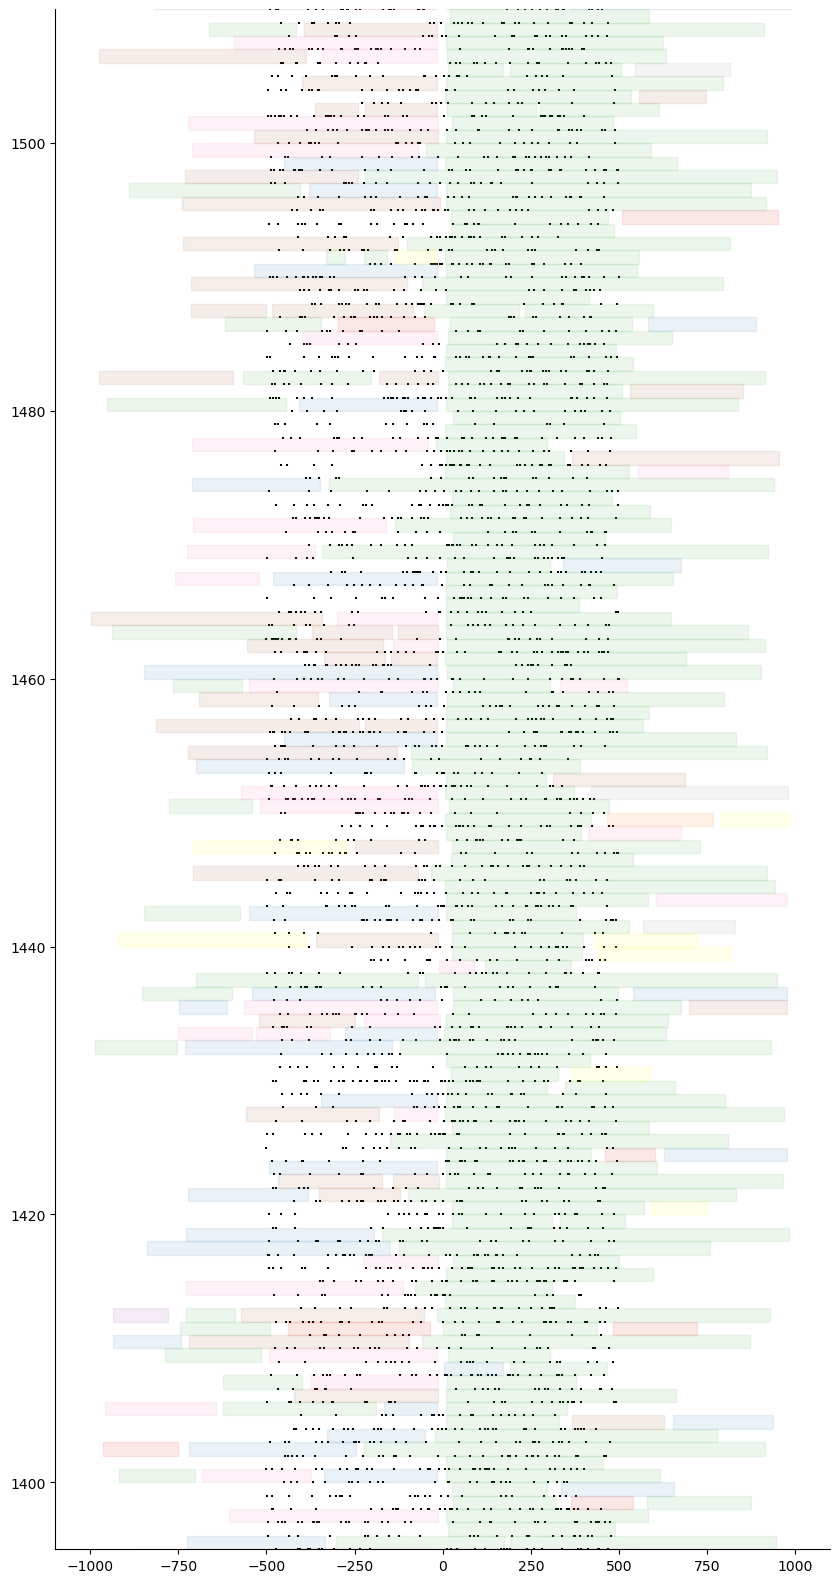

In [1027]:
# sort spikes by chosen node
node_sorted = np.sort(choice_df.node.values)
node_ind = np.argsort(choice_df.node.values)
choice_spikes_sorted = choice_spikes[node_ind,:,:]

cell=1
cell_spikes = choice_spikes_sorted[:,:,cell]

# plot spike raster
X, Y = np.where(cell_spikes)
plt.close('all')
plt.figure(figsize=(10,20))
plt.scatter(Y-500, X, marker = "|", c="k", s=1)
sns.despine()

choice_starts = choice_df.start_time.values
choice_stops = choice_df.stop_time.values

for ii in range(choice_spikes.shape[0]):
    
        n_choice = node_ind[ii]
        choice_start = choice_starts[n_choice]
        choice_stop = choice_stops[n_choice]
        fixations_per_choice = all_fixations[(all_fixations.start_time>choice_start-500) & 
                                             (all_fixations.stop_time<choice_stop+500) ]
    
        fixation_starts = fixations_per_choice.start_time.values - choice_start - 500
        fixation_stops = fixations_per_choice.stop_time.values - choice_start - 500
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for jj in range(len(fixations_per_choice)):
            plt.fill_betweenx([ii, ii+1],fixation_starts[jj],fixation_stops[jj],color = colors[fixation_nodes[jj]],alpha=0.1)


y11 = np.where(node_sorted==11)[0]
plt.ylim(y11[0],y11[-1])
plt.xlim(-500,500)
# plt.savefig('HPC Unit '+str(cell)+' fixation.jpg')

In [991]:
# define fav state
cell = 1
lamda_i = np.array([choice_spikes[data_labels == g, 450:550, cell].mean() 
          for g in np.arange(16)])*1000
print(lamda_i)
print(np.argsort(lamda_i))

[21.410257 24.832535 29.263157 28.709679 21.782179 23.762377 25.333334
 24.418606 23.800001 25.64815  26.336634 33.448277 24.235292 27.
 26.763285 30.304878]
[ 0  4  5  8 12  7  1  6  9 10 14 13  3  2 15 11]


In [993]:
lamda_i = np.array([choice_spikes[data_labels == g, 750:850, cell].mean() 
          for g in np.arange(16)])*1000
print(lamda_i)
print(np.argsort(lamda_i))

[28.141026 33.25359  29.473684 28.225805 28.415842 29.009901 28.11111
 37.093025 33.550003 30.092594 25.346535 32.327583 30.705883 29.7
 32.415462 31.463415]
[10  6  0  3  4  5  2 13  9 12 15 11 14  1  8  7]


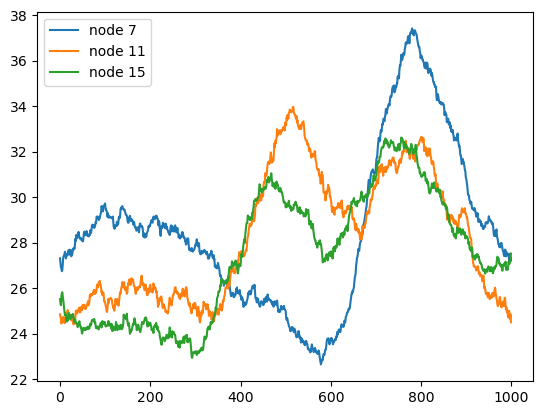

In [1157]:
cell = 1
trace7 = movmean(choice_spikes[choice_df.node==7, :, cell].mean(axis=0)*1000, w=75).flatten() 
trace11 = movmean(choice_spikes[choice_df.node==11, :, cell].mean(axis=0)*1000, w=75).flatten() 
trace15 = movmean(choice_spikes[choice_df.node==15, :, cell].mean(axis=0)*1000, w=75).flatten() 

plt.close('all')
plt.figure()
plt.plot(trace7,label='node 7')
plt.plot(trace11,label='node 11')
plt.plot(trace15,label='node 15')
plt.legend()

(20.0, 40.0)

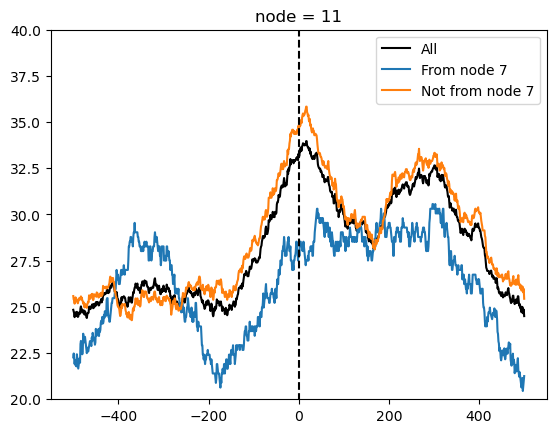

In [1177]:
# whether from node 7 or not?

cell = 1
node = 11

ind11 = np.where(choice_df.node.values==11)[0]
pre_node = choice_df.iloc[ind11 - 1,:].node.values

plt.close('all')
plt.figure()

trace = movmean(choice_spikes[choice_df.node==node, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='All',color='k')

temp_ind = ind11[pre_node==7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='From node 7')

temp_ind = ind11[pre_node!=7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='Not from node 7')

plt.legend()
plt.plot([0,0],[0,50],'k--')
plt.title('node = '+str(node))
plt.ylim([20,40])

In [1185]:
# check when the FR rates

71

(20.0, 40.0)

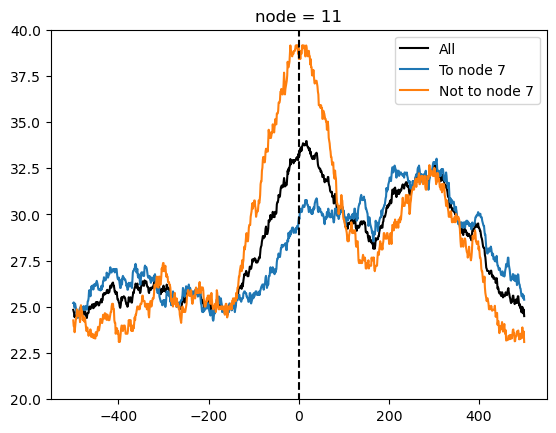

In [1181]:
# whether going to node 7 or not?

cell = 1
node = 11

ind11 = np.where(choice_df.node.values==11)[0]
pre_node = choice_df.iloc[ind11 + 1,:].node.values

plt.close('all')
plt.figure()

trace = movmean(choice_spikes[choice_df.node==node, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='All',color='k')

temp_ind = ind11[pre_node==7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='To node 7')

temp_ind = ind11[pre_node!=7]
trace = movmean(choice_spikes[temp_ind, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='Not to node 7')

plt.legend()
plt.plot([0,0],[0,50],'k--')
plt.title('node = '+str(node))
plt.ylim([20,40])

Text(0.5, 1.0, 'node = 11')

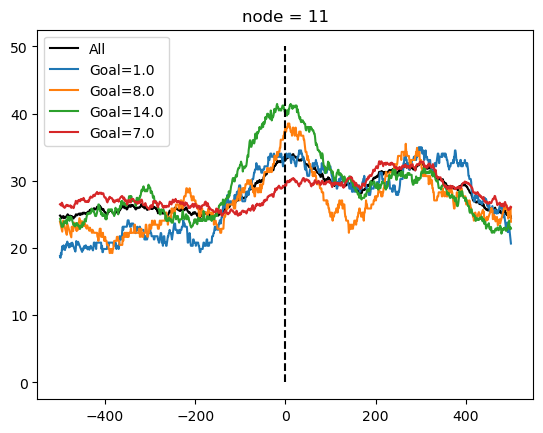

In [1087]:
# is node 11 goal dependent?

cell = 1
node = 11
goals = choice_df.target.unique()

plt.close('all')
plt.figure()

trace = movmean(choice_spikes[choice_df.node==node, :, cell].mean(axis=0)*1000, w=75).flatten() 
plt.plot(np.linspace(-500,500,len(trace)),trace,label='All',color='k')

for gg in goals:
    trace = movmean(choice_spikes[(choice_df.node==node) & (choice_df.target==gg), 
                      :, cell].mean(axis=0)*1000, w=75).flatten() 
    plt.plot(np.linspace(-500,500,len(trace)),trace,label='Goal='+str(gg))

plt.legend()
plt.plot([0,0],[0,50],'k--')
plt.title('node = '+str(node))

In [1089]:
choice_df.query('node==11').groupby('target').count()

,start_time,stop_time,trial,step,trialerror,nsteps,start,block,blocktrialnumber,node,t_on,graph_distance,spatial_distance,window_size,nodes,timeseries,use_tele
target,,,,,,,,,,,,,,,,,
1.0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
7.0,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
8.0,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
14.0,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


In [767]:
all_fixations = nwbfile.intervals["fixations"].to_dataframe().query("(duration >= 50) & (trialerror == 0)")

In [421]:
choice_spikes.shape[2]

80

In [439]:
null.shape

(80, 1000, 17)

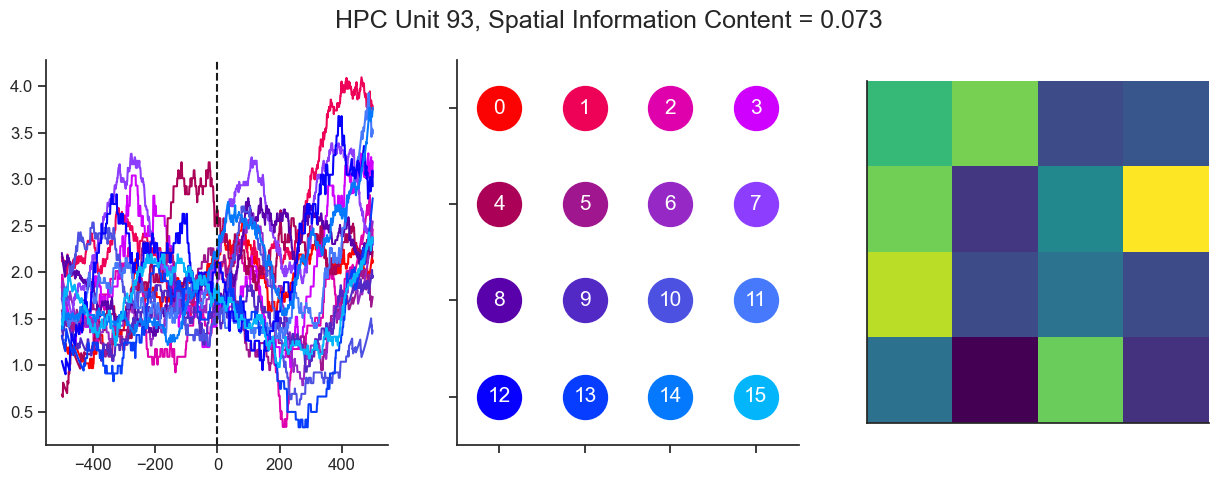

In [441]:
for cell in range(choice_spikes.shape[2]):
    IC = calculate_IC(choice_spikes, choice_df, cell)
    plt.close('all')
    fig, ax = plot_psth(choice_spikes, choice_df, cell)
    fig.suptitle("HPC Unit %i, Spatial Information Content = %.3f" 
                 % (cell, IC))
    plt.savefig('Session 3, HPC Unit '+str(cell)+'.jpg')

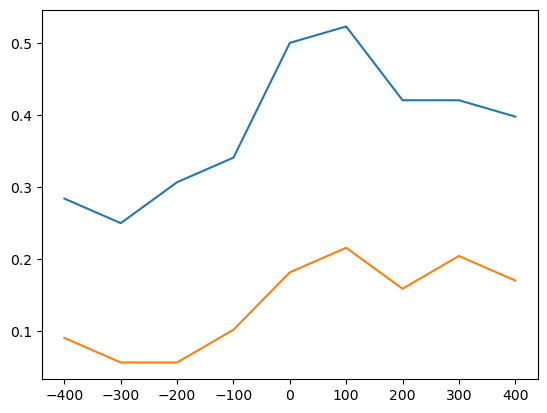

In [665]:
plt.close('all')
plt.plot(np.arange(-400,500,100),sig.mean(axis=0))
plt.plot(np.arange(-400,500,100),np.mean(sig*FRpass*(score>0.1),axis=0))

In [9]:
def calculate_IC(spikes, df, cell):
    """
    Calculate the spatial information content of a cell during the 300ms choice fixation period.

    Parameters:
    data : object
        An object containing the spike data and step information.
    cell : int
        The index of the cell for which the information content is calculated.

    Returns:
    float
        The spatial information content in bits per second.
    """
    #n_units = len(cell_list)
    mean_fr_by_node = np.zeros(16)
    p_node = np.zeros(16)
    for node in range(16):
        idx = df.node.values == node
        mean_fr_by_node[node] = spikes[idx, 500:800, cell].mean(axis=(0, 1))
        p_node[node] = idx.sum()/len(idx)
    mean_fr = spikes[:, 500:800, cell].mean(axis=(0, 1)).mean()

    term1 = mean_fr_by_node
    term2 = np.log2(mean_fr_by_node/mean_fr)
    term3 = p_node
    IC = (np.sum(term1*term2*term3))*1000
    
    return IC

def plot_psth(spikes, df, cell):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), width_ratios=[1, 1, 1])
    mean_fr = np.zeros([16])
    for node in np.arange(0, 16):
        idx = df.node.values == node
        x, y = xy(node, 4, 4)
        ax[1].scatter(x, y, s=1000, color = cmap_2d[x, y])
        ax[1].text(x, y, str(node), fontsize=15, ha='center', va='center', color='w')
        trace = movmean(spikes[idx, :, cell].mean(axis=0)*1000, w=75).flatten()
        mean_fr[node] = trace[500:800].mean()
        t = np.arange(-500, 500)
        ax[0].plot(t, trace, c= cmap_2d[x, y])
    mean_fr = mean_fr.reshape(4, 4)
    ax[0].axvline(0, color='k', linestyle='--')
    
    ax[1].set_xlim([-0.5, 3.5])
    ax[1].set_ylim([-0.5, 3.5])
    ax[1].set_xticks([0, 1, 2, 3], labels = ["", "", "", ""])
    ax[1].set_yticks([0, 1, 2, 3], labels = ["", "", "", ""])
    ax[1].invert_yaxis()  # Invert the y-axis
    ax[2].imshow(mean_fr, cmap='viridis', vmin=mean_fr.min(), vmax=mean_fr.max())
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    sns.despine()
    return fig, ax 

cell = 28
IC = calculate_IC(choice_spikes, choice_df, cell)
fig, ax = plot_psth(choice_spikes, choice_df, cell)
fig.suptitle("HPC Unit %i, Spatial Information Content = %.3f" % (cell, IC))

NameError: name 'choice_spikes' is not defined

# Fixation table

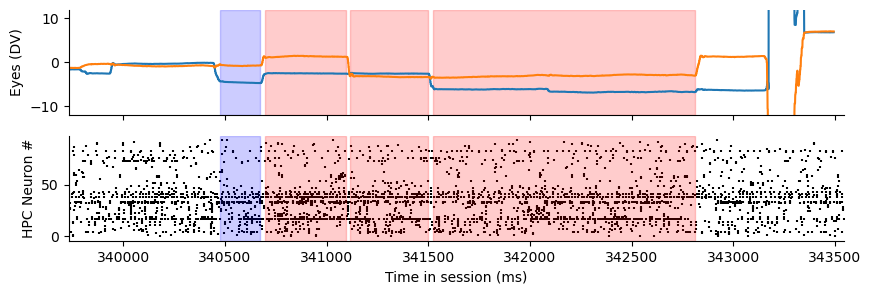

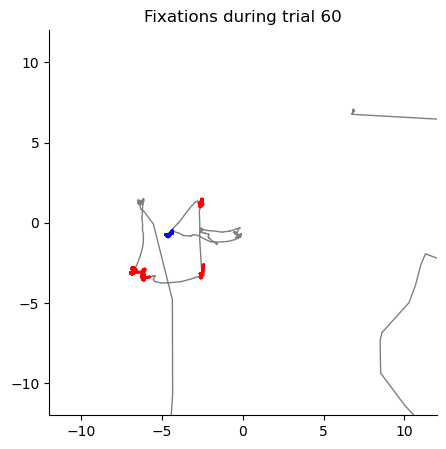

In [13]:
# get neural data associated with a trial:
# timeseries in the 'timeseries' column must be indexed with integers
neural_idx = 0
eye_idx = 2

unitNames = nwbfile.units.to_dataframe()
# get good units
unit_idx = np.where((unitNames.region == "HPC") & (unitNames.group == "good") & (unitNames.drift <= 2) & (unitNames.fr >= 1))[0]


# pull trial for a single trial
trial = 60
spikes = trial_df.iloc[trial, :].timeseries[neural_idx]
eyes = trial_df.iloc[trial, :].timeseries[eye_idx]

fig, ax = plt.subplots(2, 1, figsize=(10, 3), height_ratios=[1, 1], sharex=True)
# plot eyetracking data
ax[0].plot(eyes.timestamps, eyes.data)
ax[0].set_ylabel("Eyes (DV)")
ax[0].set_ylim([-12, 12])

# plot spike raster
X, Y = np.where(spikes.data[:, unit_idx])
X = (X + spikes.timestamps[0])
ax[1].scatter(X, Y, marker = "|", c="k", s=1)
ax[1].set_xlim(spikes.timestamps[0], spikes.timestamps[-1])
ax[1].set_ylabel("HPC Neuron #")
ax[1].set_xlabel("Time in session (ms)")
sns.despine()

fixations_during_trial = nwbfile.intervals["fixations"].to_dataframe().query("(trial == @ trial) & (duration >= 50)")
for k in range(2):
    for _, fix in fixations_during_trial.iterrows():
        if fix.active_prob > 0.1:
            ax[k].axvspan(fix.start_time, fix.stop_time, color='r', alpha=0.2)
        else:
            ax[k].axvspan(fix.start_time, fix.stop_time, color='b', alpha=0.2)
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(eyes.data[:, 0], eyes.data[:, 1], alpha=0.5, c="k", lw=1)
for k in range(2):
    for _, fix in fixations_during_trial.iterrows():
        idx = (eyes.timestamps >= (fix.start_time)) & (eyes.timestamps <= fix.stop_time)
        fixation_trace = eyes.data[idx, :]
        if fix.active_prob > 0.1:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c='r', lw=2)
        else:
            ax.plot(fixation_trace[:, 0], fixation_trace[:, 1], c='b', lw=2)

ax.set_ylim([-12, 12])
ax.set_xlim([-12, 12])
ax.set_title("Fixations during trial %i" % trial)
sns.despine()

In [474]:
trial_df.iloc[trial, :].nodes

'14,10,6,5,1'